# Volatility Prediction

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

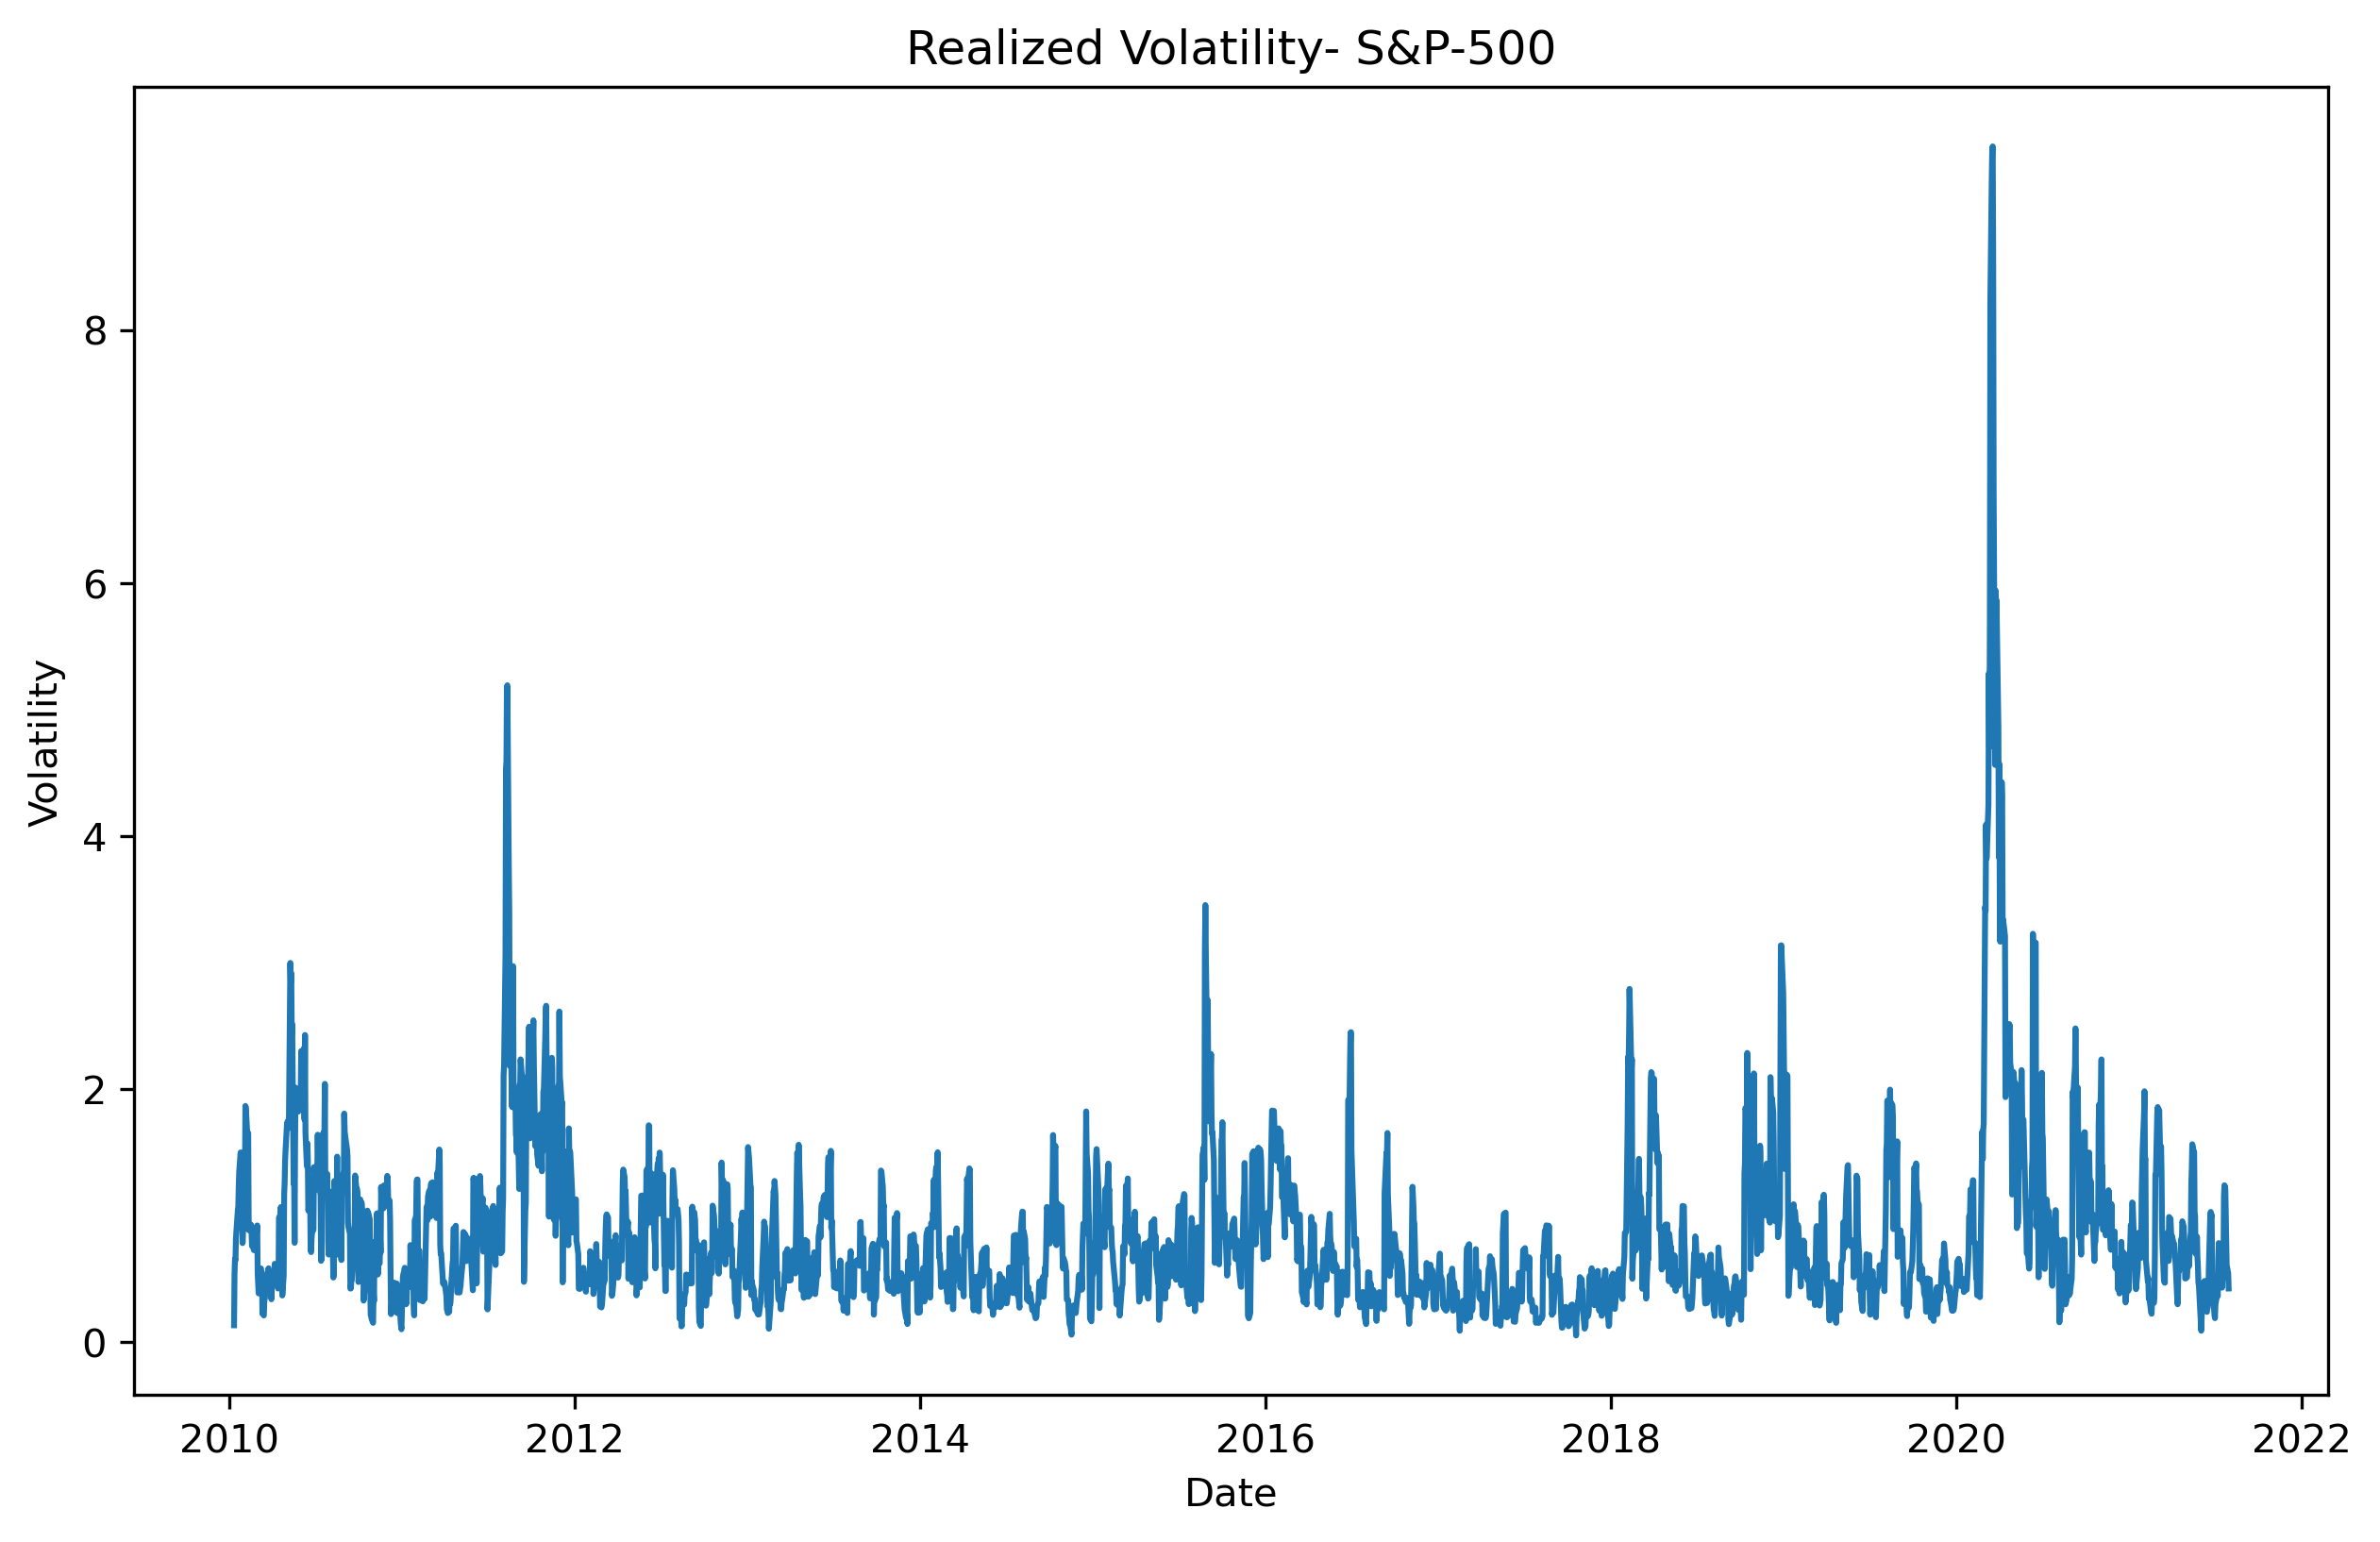

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()

In [5]:
retv = ret.values

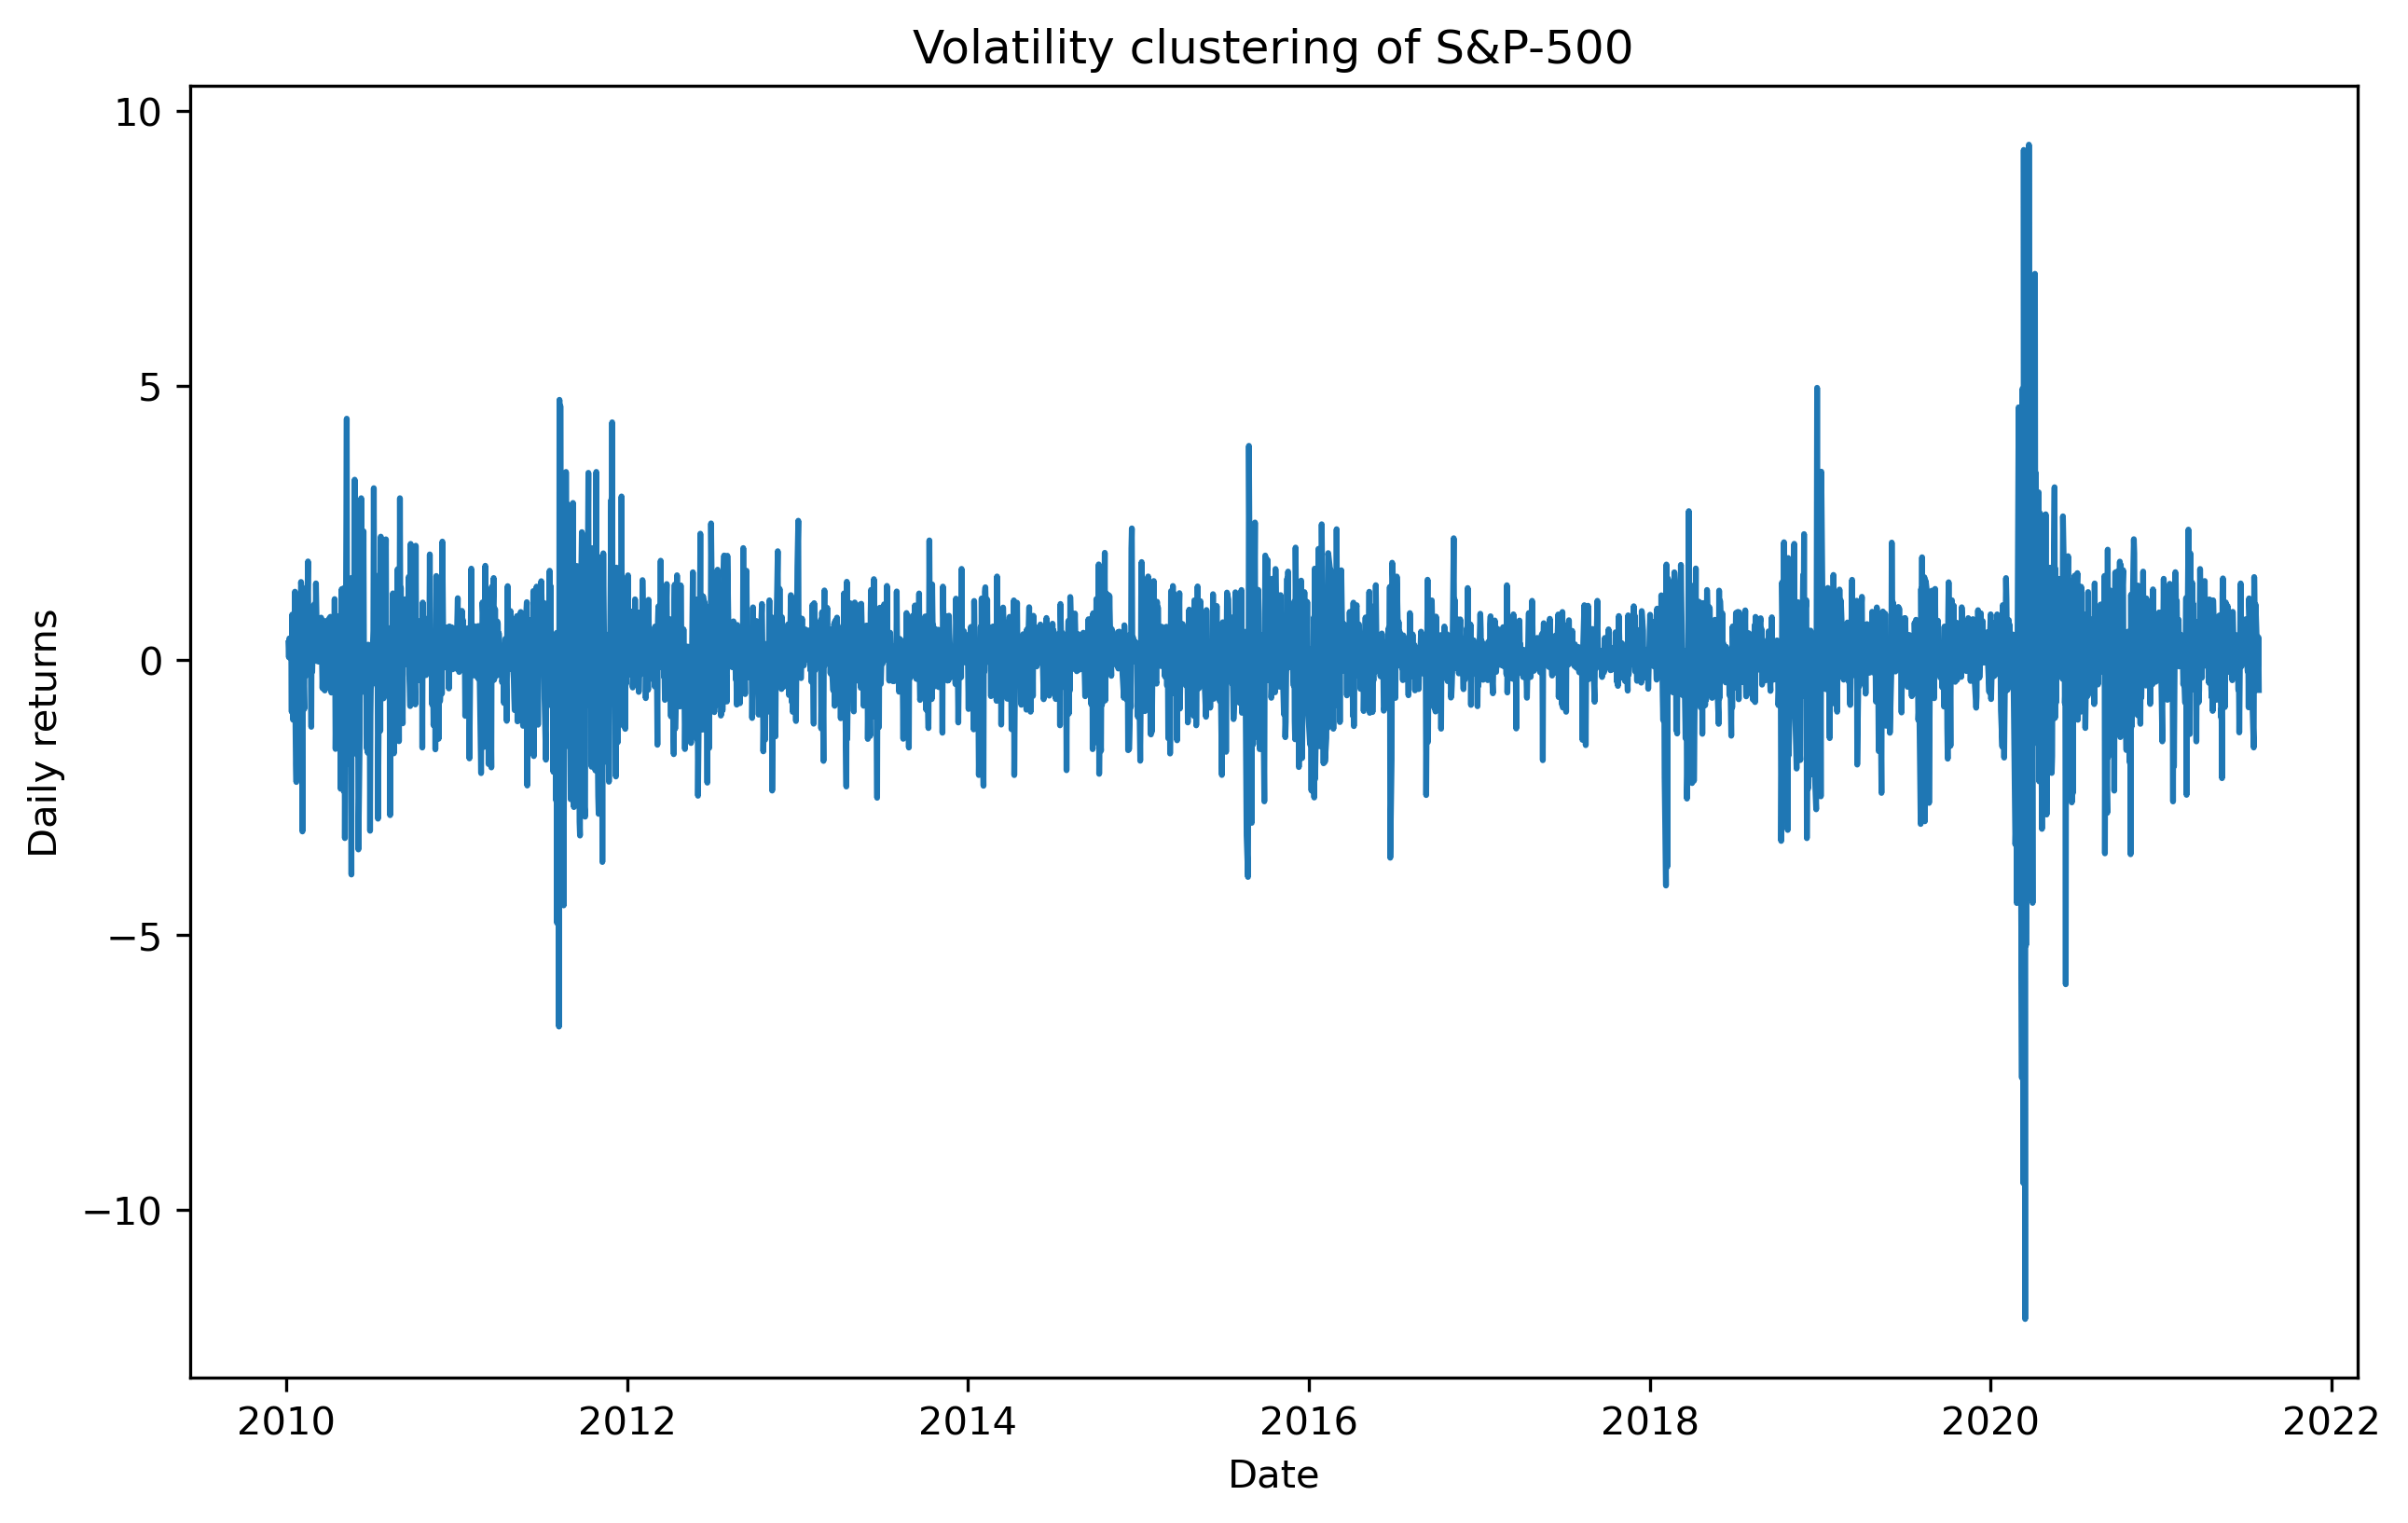

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500') 
plt.ylabel('Daily returns')
plt.xlabel('Date') 
plt.show()

## ARCH

In [7]:
n = 252
split_date = ret.iloc[-n:].index

In [8]:
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * 
                             (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(0.634156491639156, 0.46673132307801635)

In [9]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks


In [10]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1451.575703051802

In [11]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                              method='Nelder-Mead', 
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
          .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [12]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1384.454903510855
             x: [ 7.015e-01  3.913e-01]
           nit: 30
          nfev: 58
 final_simplex: (array([[ 7.015e-01,  3.913e-01],
                       [ 7.016e-01,  3.913e-01],
                       [ 7.016e-01,  3.914e-01]]), array([ 1.384e+03,  1.384e+03,  1.384e+03]))

Resulting params = [0.70152949 0.39126701]


In [13]:
def arch_apply(ret):
        omega = params[0]
        alpha = params[1]
        T = len(ret)
        sigma2_arch = np.zeros(T + 1)
        sigma2_arch[0] = np.var(ret)
        for t in range(1, T):
            sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
        return sigma2_arch

In [14]:
sigma2_arch = arch_apply(ret)

In [15]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Fri, Aug 04 2023   Df Residuals:                     2913
Time:                        20:55:22   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

In [16]:
bic_arch = []

for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Fri, Aug 04 2023   Df Residuals:                     2913
Time:                        20:55:23   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

In [17]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, 
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):] 
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0896


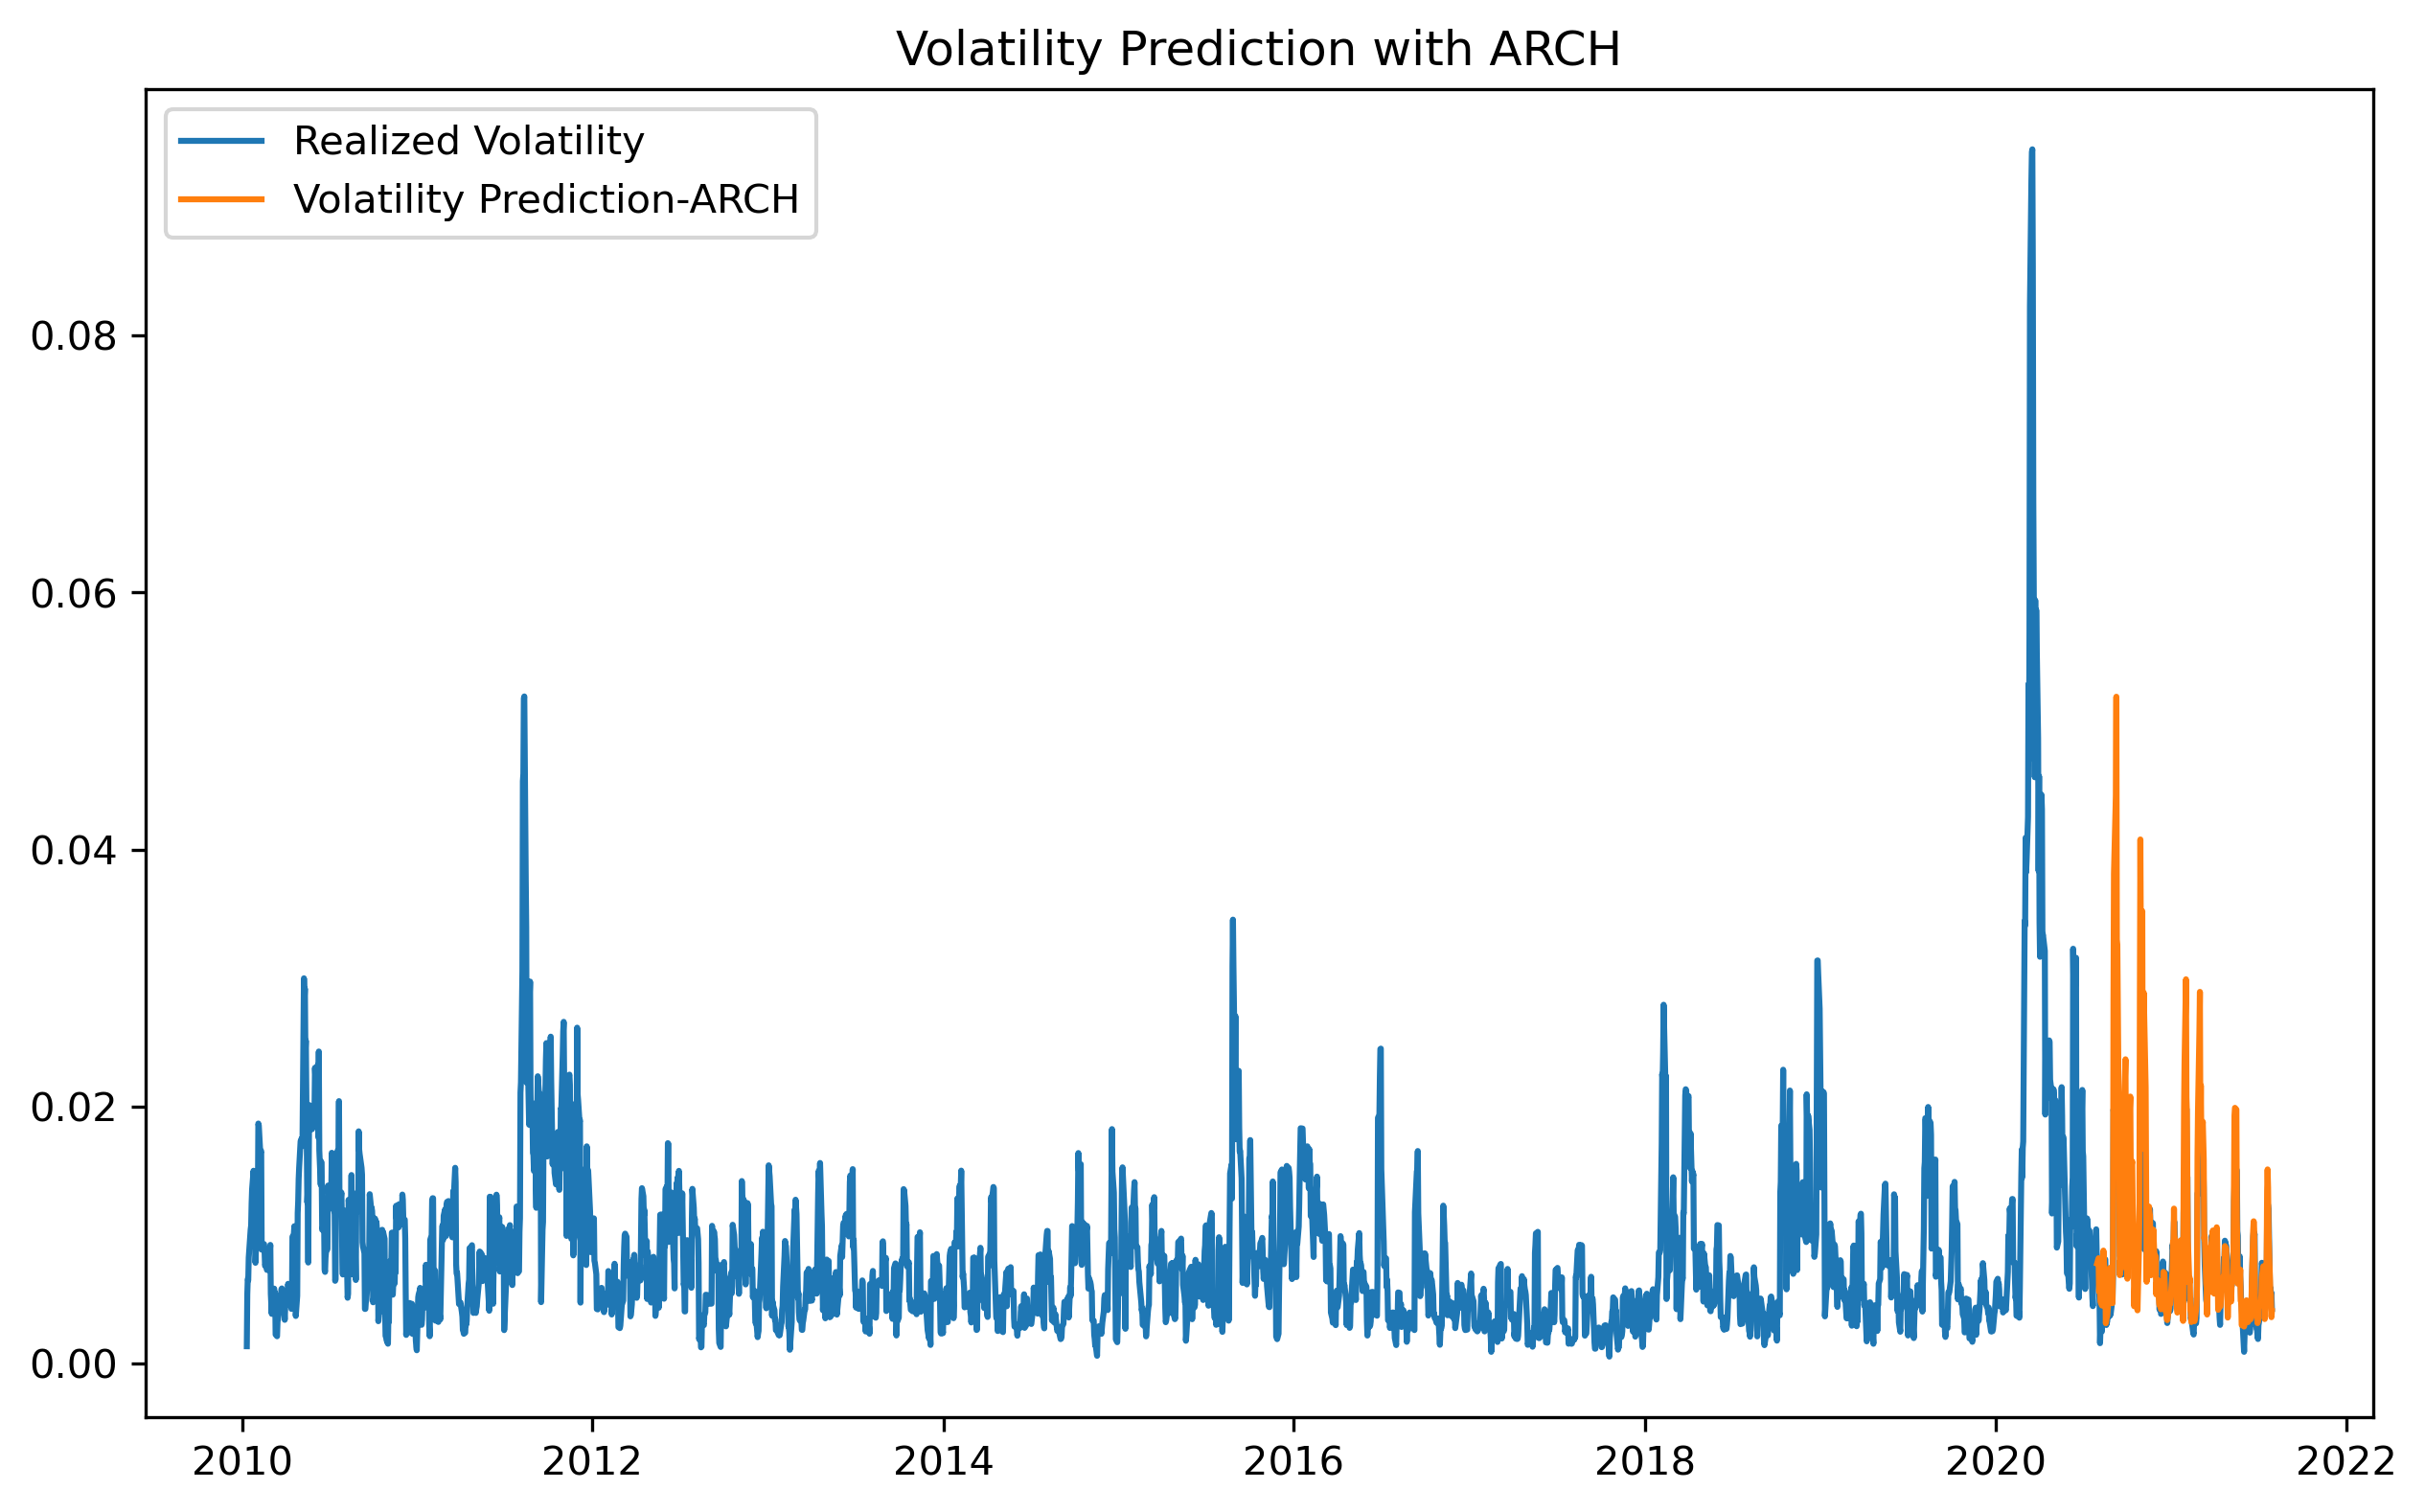

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

## GARCH

In [19]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha, and beta are \n{}\n{}\n{}'
      .format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta are 
0.4350565592754937
0.5130099184547643
0.02663563269868552


In [20]:
retv = ret.values

In [21]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    T =  len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

In [22]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log likelihood  is {:.4f}'.format(logliks))

The Log likelihood  is 1386.4565


In [23]:
def garch_constraint(initial_parameters):  
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [24]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [25]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood, 
                              x0=initial_parameters,
                              constraints=np.array([1 - alpha - beta]), 
                              bounds=bounds, args = (retv),
                              method='Nelder-Mead',
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'\
          .format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params

In [26]:
params = opt_paramsG(initial_parameters, retv)


Results of Nelder-Mead minimization
-----------------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 978.4381678874333
             x: [ 3.925e-02  1.744e-01  7.894e-01]
           nit: 99
          nfev: 172
 final_simplex: (array([[ 3.925e-02,  1.744e-01,  7.894e-01],
                       [ 3.929e-02,  1.745e-01,  7.893e-01],
                       [ 3.927e-02,  1.744e-01,  7.894e-01],
                       [ 3.928e-02,  1.744e-01,  7.894e-01]]), array([ 9.784e+02,  9.784e+02,  9.784e+02,  9.784e+02]))
-----------------------------------

Resulting parameters = [0.0392492  0.17440926 0.78939289]


In [27]:
def garch_apply(ret):
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        T = len(ret)
        sigma2 = np.zeros(T + 1)
        sigma2[0] = np.var(ret)
        for t in range(1, T):
            sigma2[t] = omega + alpha * ret[t - 1] ** 2 +\
                        beta * sigma2[t-1]
        return sigma2

In [28]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Fri, Aug 04 2023   Df Residuals:                     2913
Time:                        20:55:39   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [29]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Fri, Aug 04 2023   Df Residuals:                     2913
Time:                        20:55:40   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [30]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0878


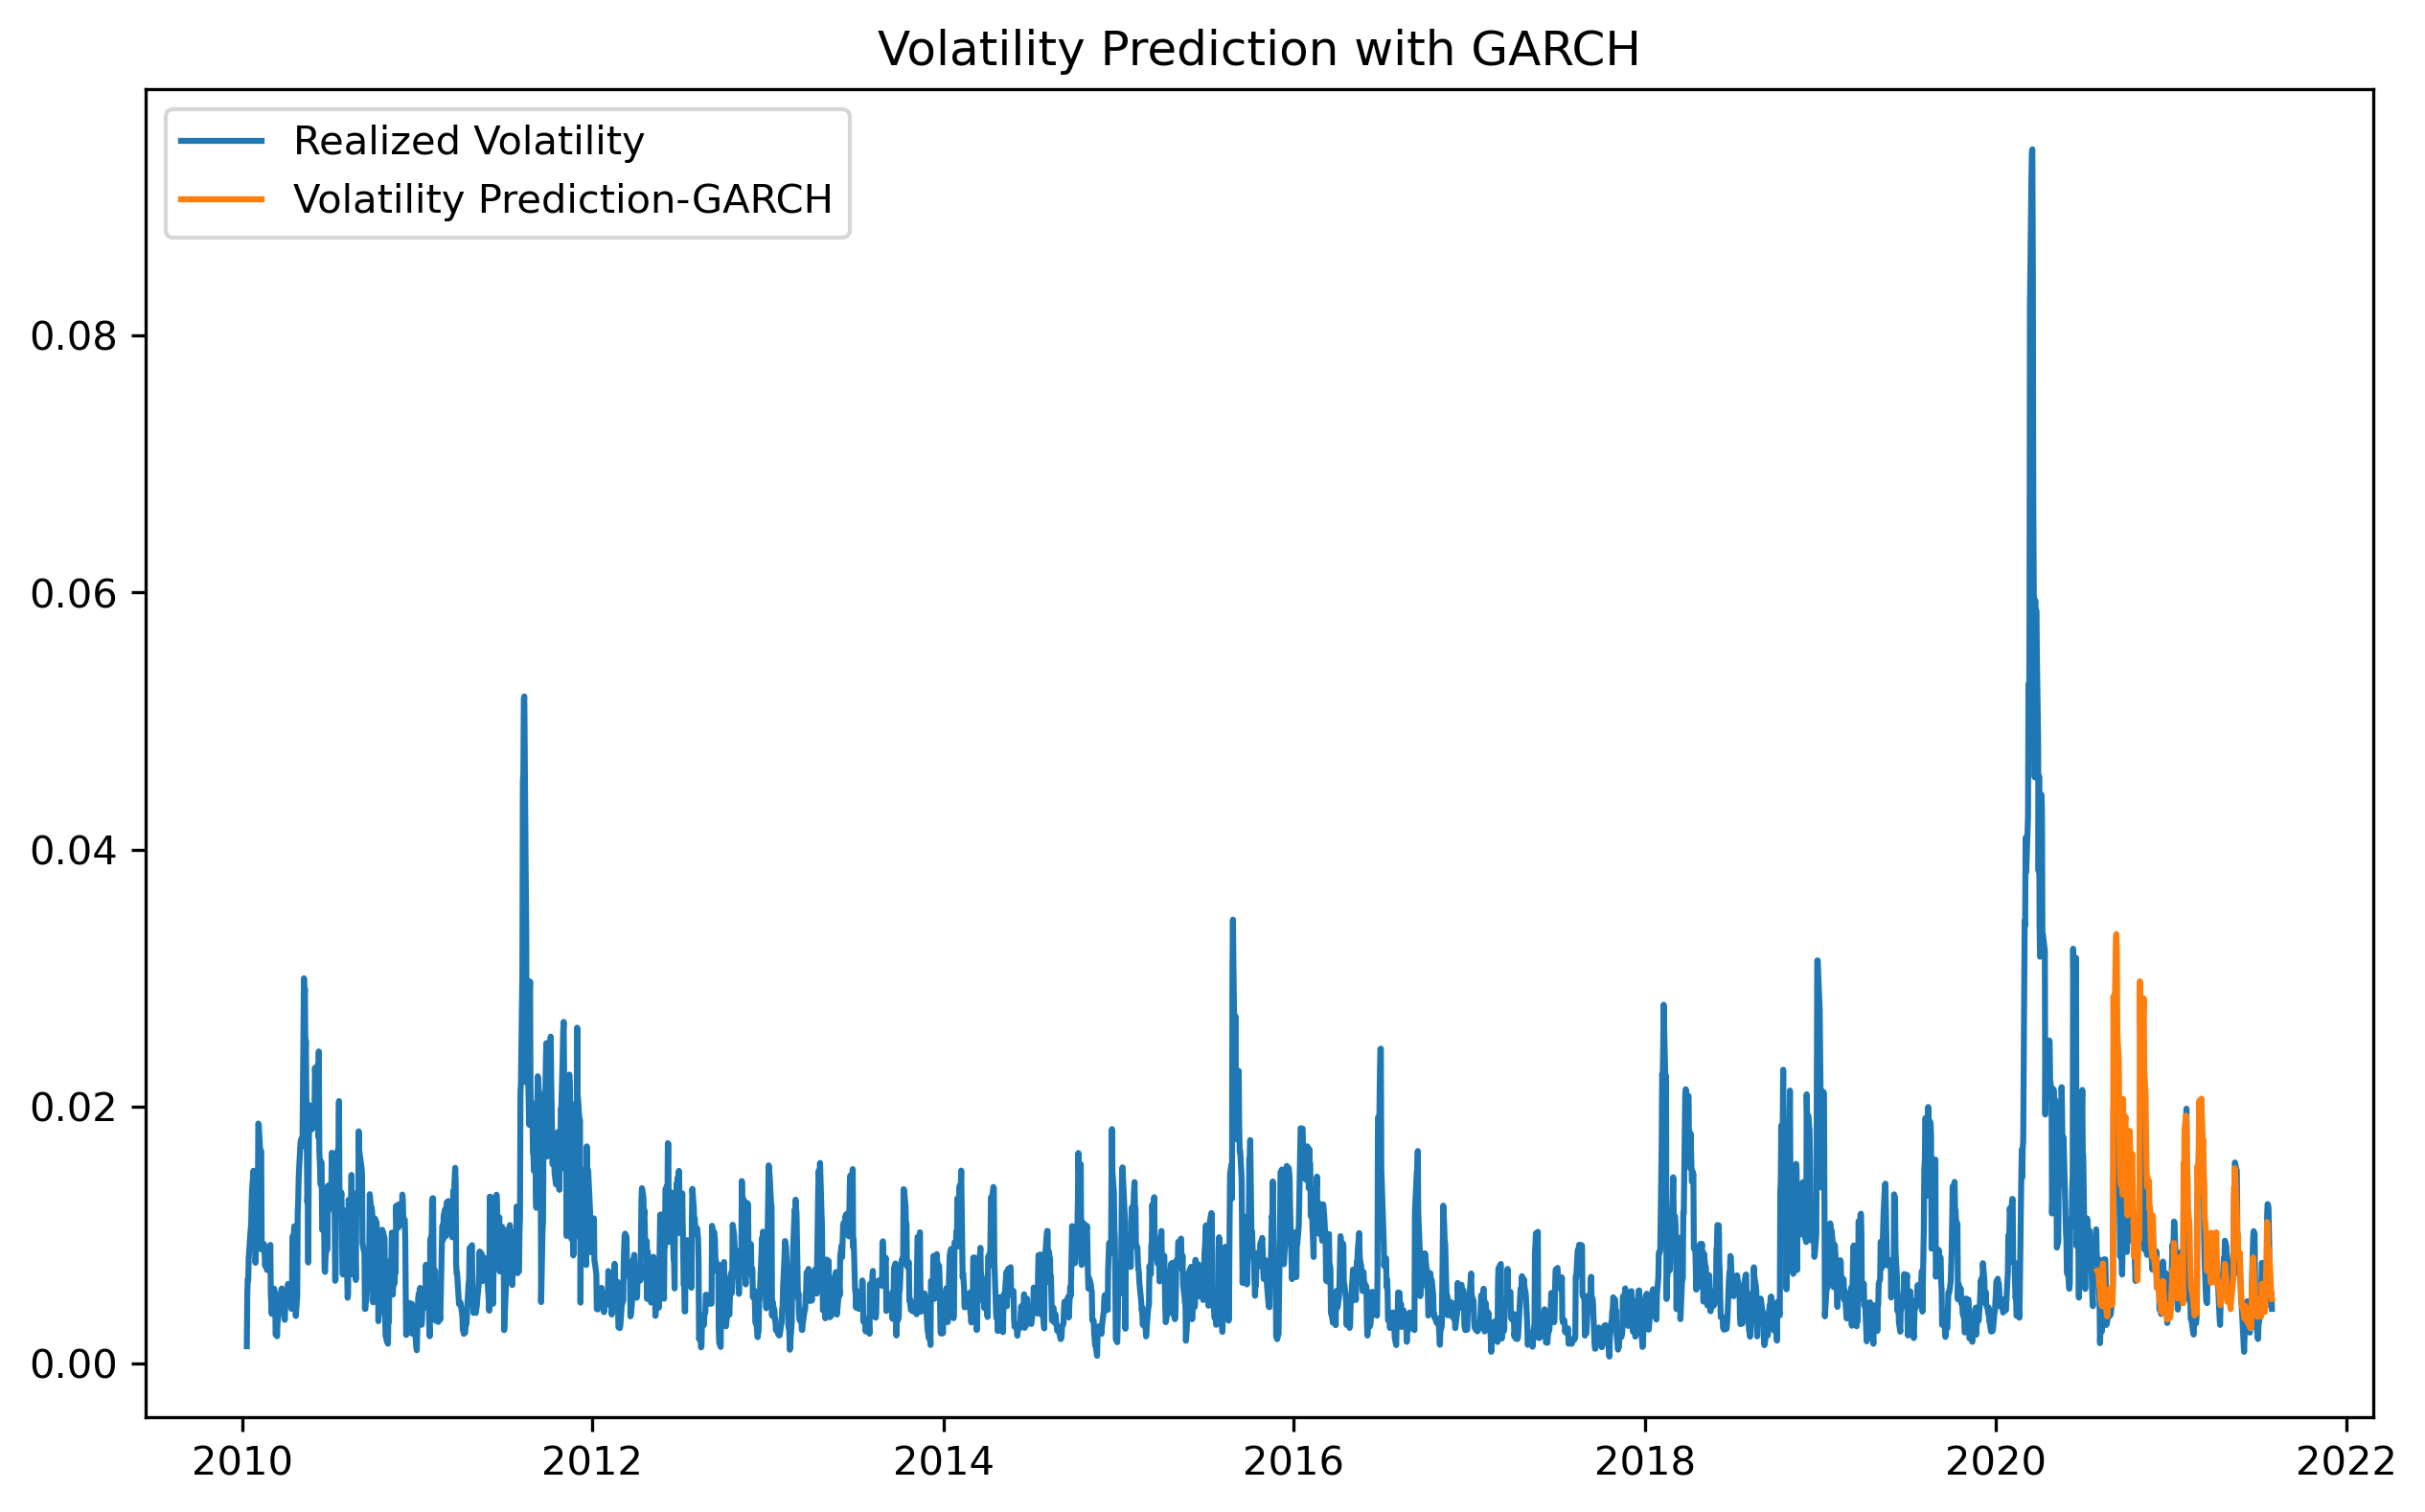

In [31]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

## GJR-GARCH

In [32]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q)\
                   .fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1,
                      q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3591.15
Distribution:                  Normal   AIC:                           7190.30
Method:            Maximum Likelihood   BIC:                           7214.21
                                        No. Observations:                 2913
Date:                Fri, Aug 04 2023   Df Residuals:                     2913
Time:                        20:55:45   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0430  7.754e-03      5.547  2.908e-08 

In [33]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                             np.sqrt(forecast_gjrgarch\
                             .variance.iloc[-len(split_date):]
                             / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'
      .format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.0882


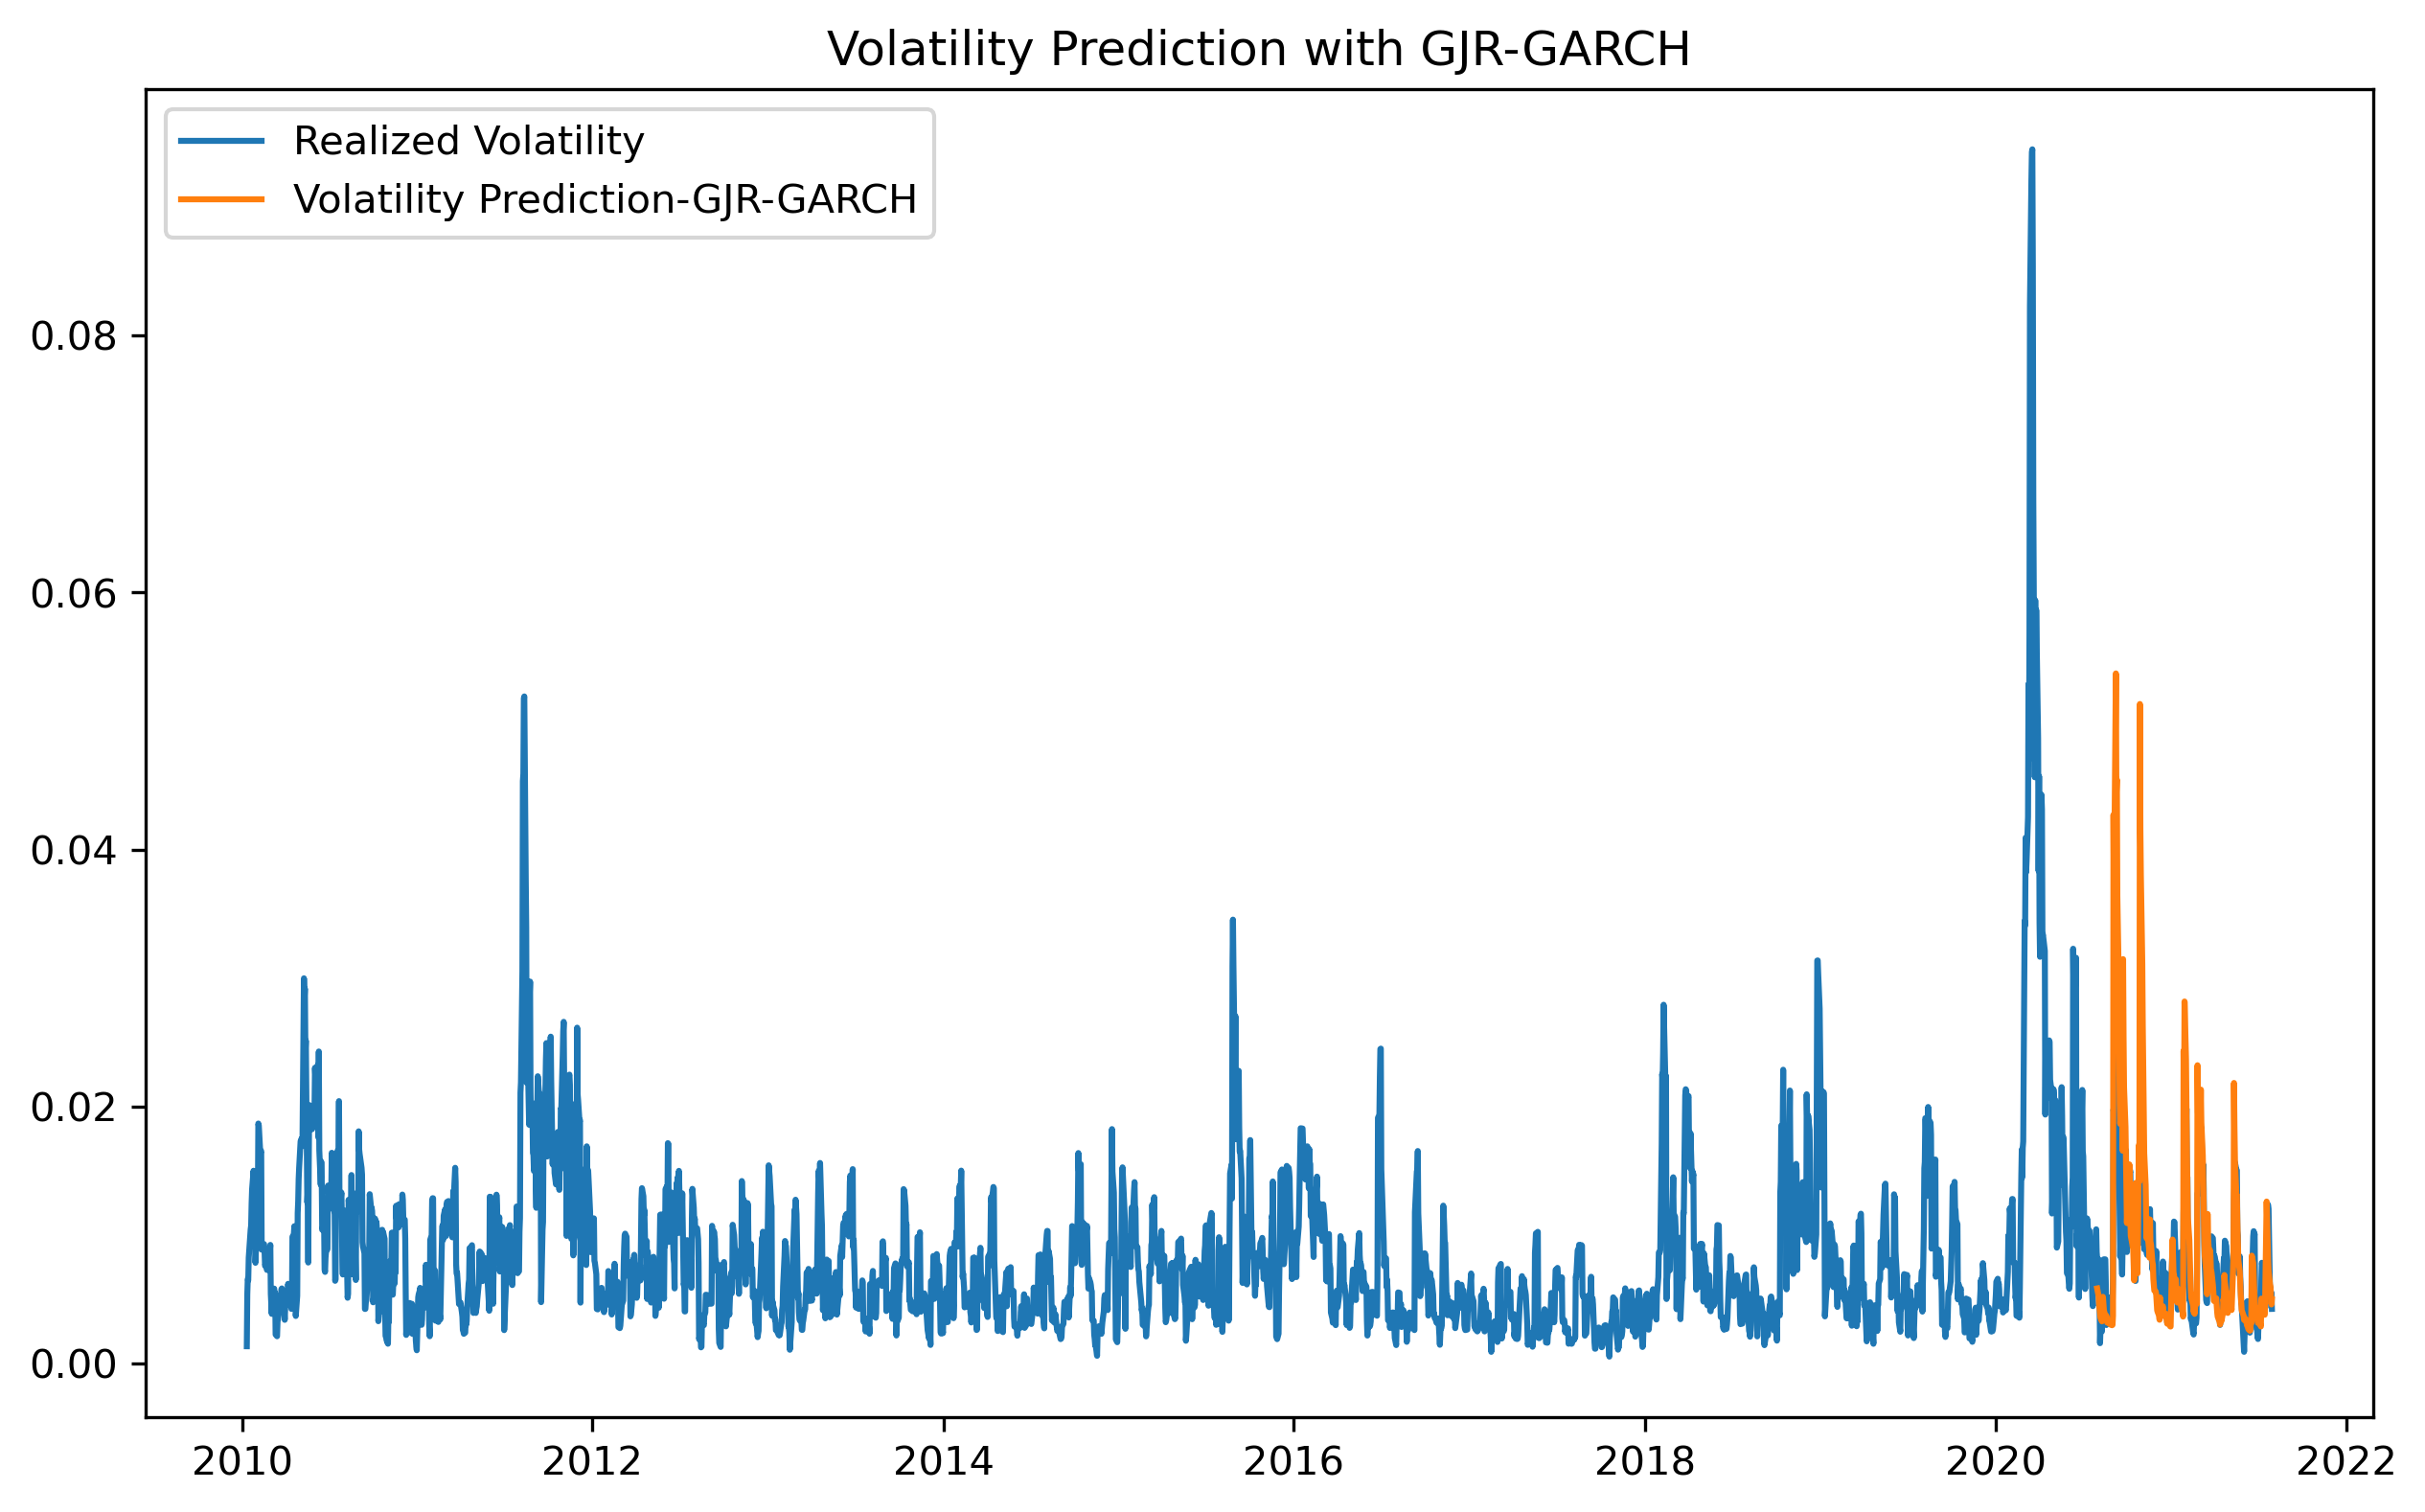

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

## EGARCH

In [35]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                 .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
         .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3673.53
Distribution:                  Normal   AIC:                           7353.05
Method:            Maximum Likelihood   BIC:                           7370.98
                                        No. Observations:                 2913
Date:                Fri, Aug 04 2023   Df Residuals:                     2913
Time:                        20:55:51   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4573e-03  6.769e-03      0.363      0.717 

In [36]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance\
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0904


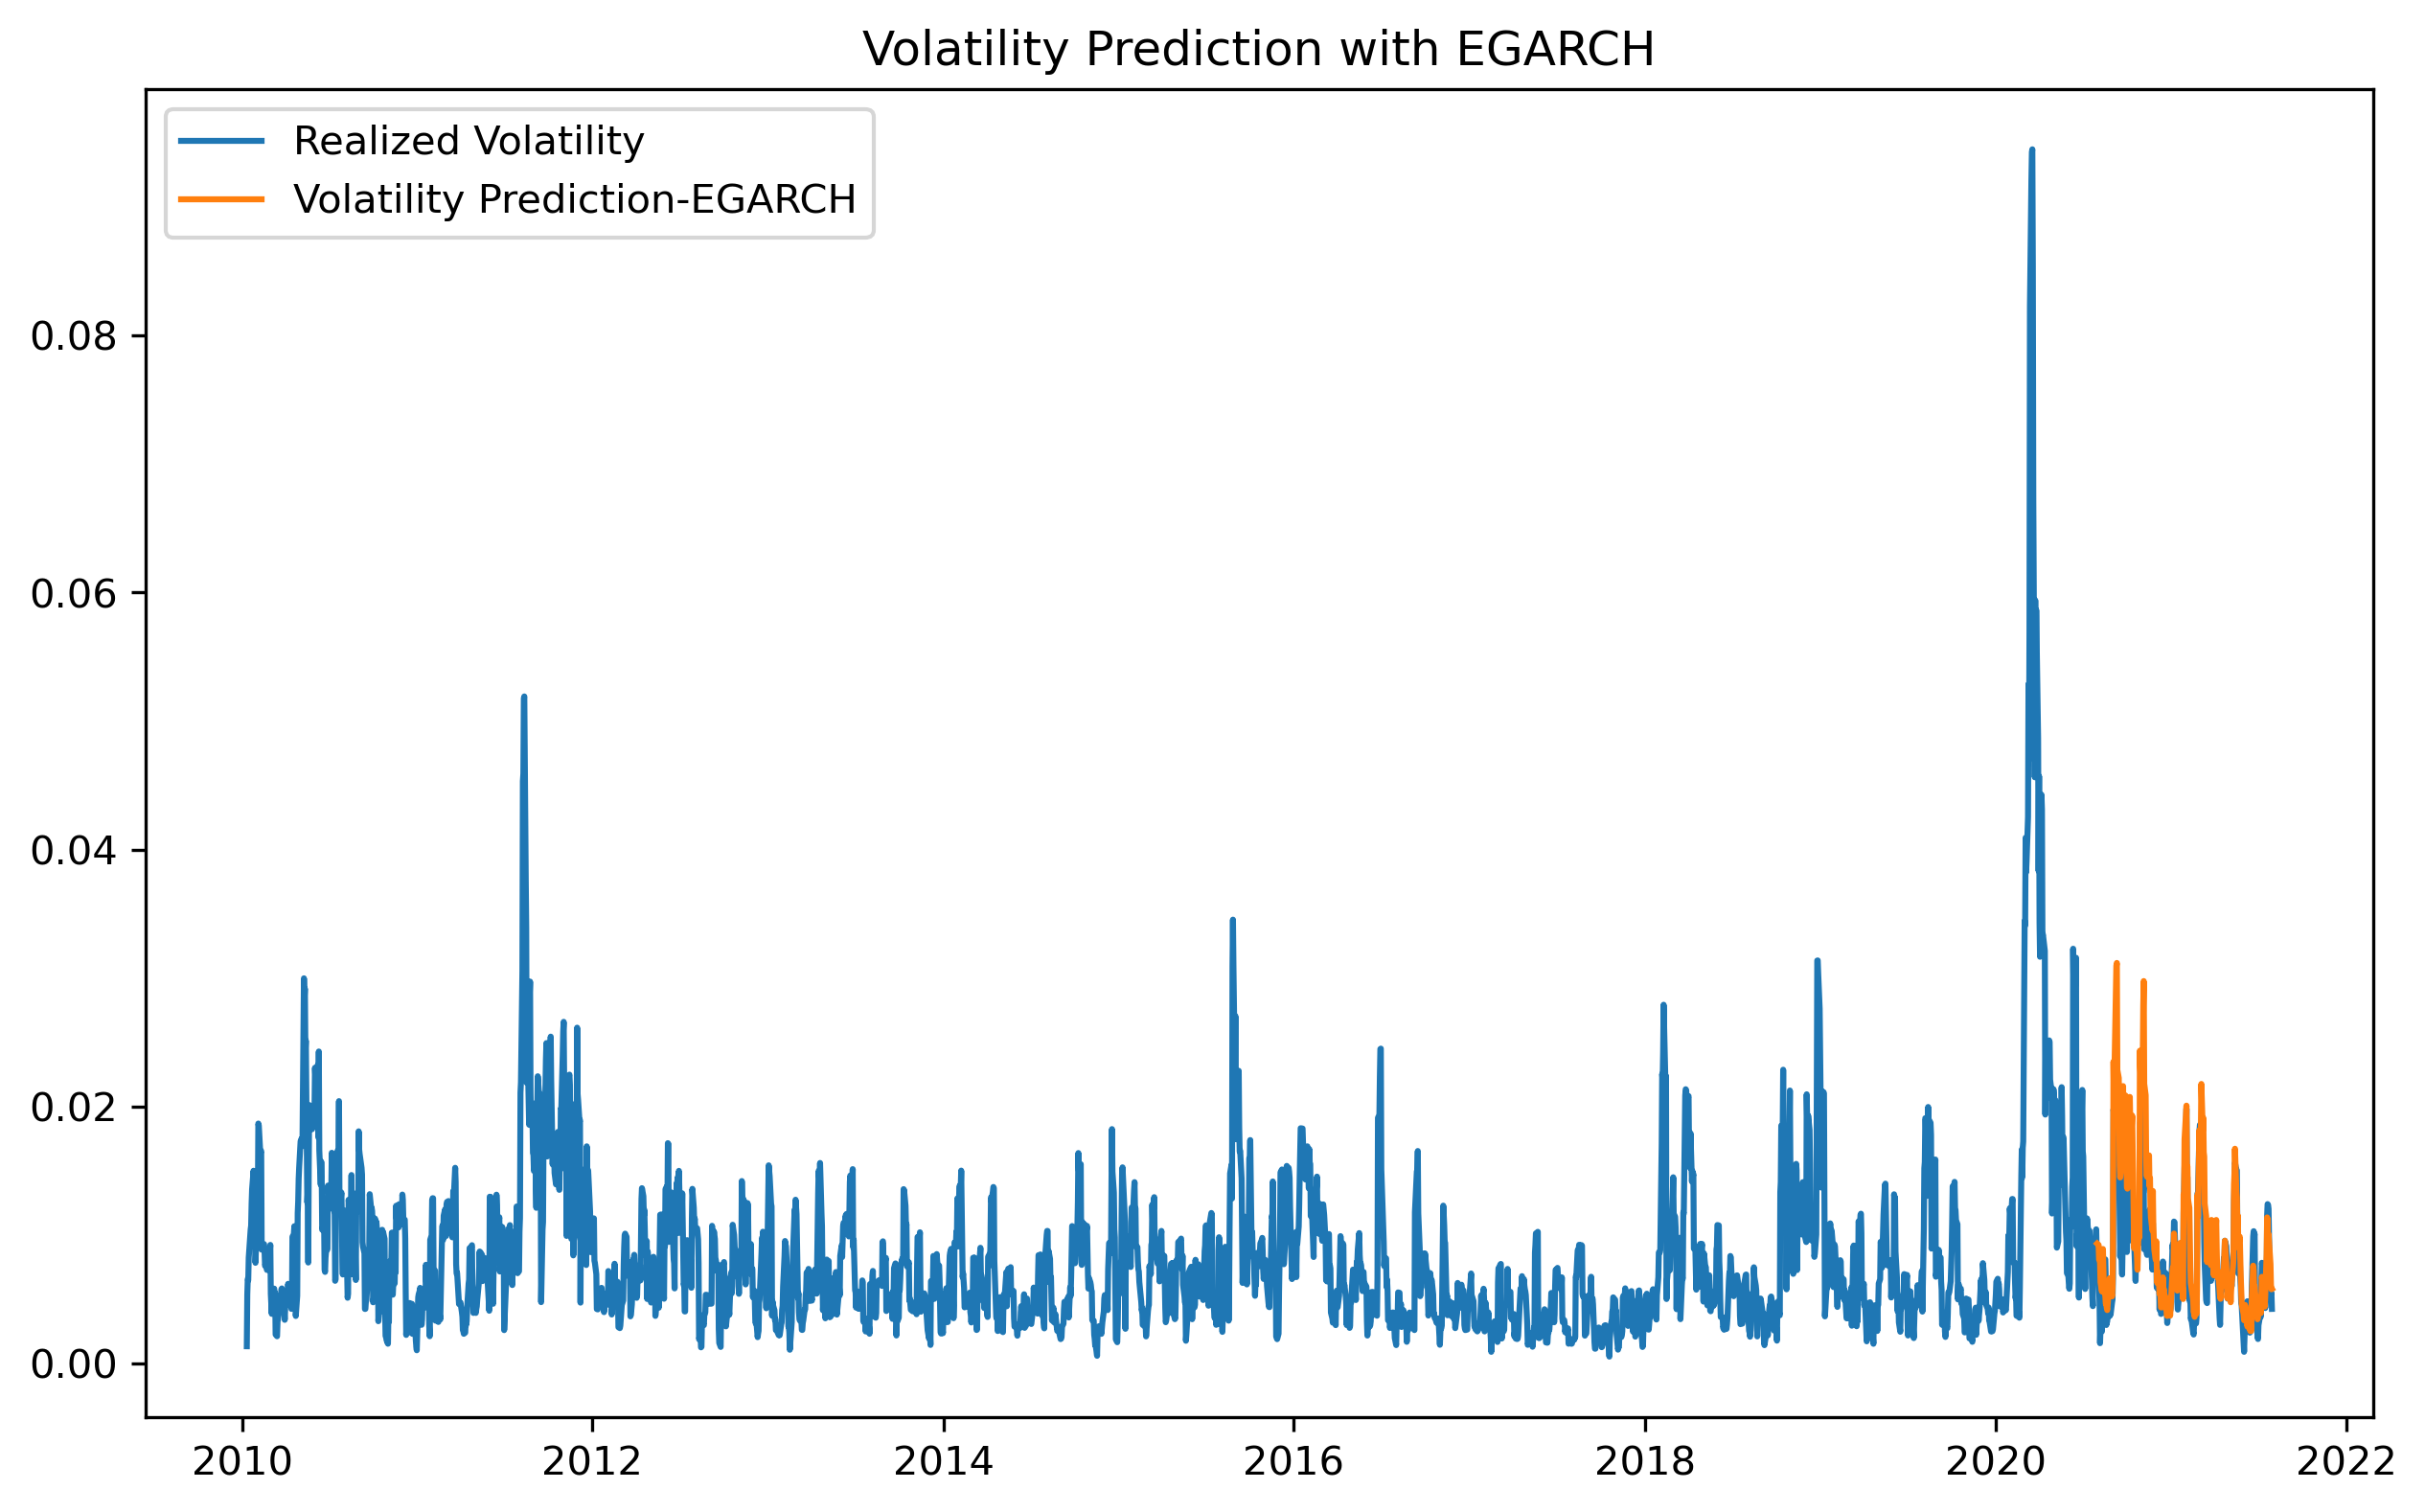

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

## SVR-GARCH

In [38]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [39]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [40]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [41]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [42]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [43]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

### SVR-GARCH-Linear

In [44]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [45]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [46]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                       predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000398


In [47]:
realized_vol.index = ret.iloc[4:].index

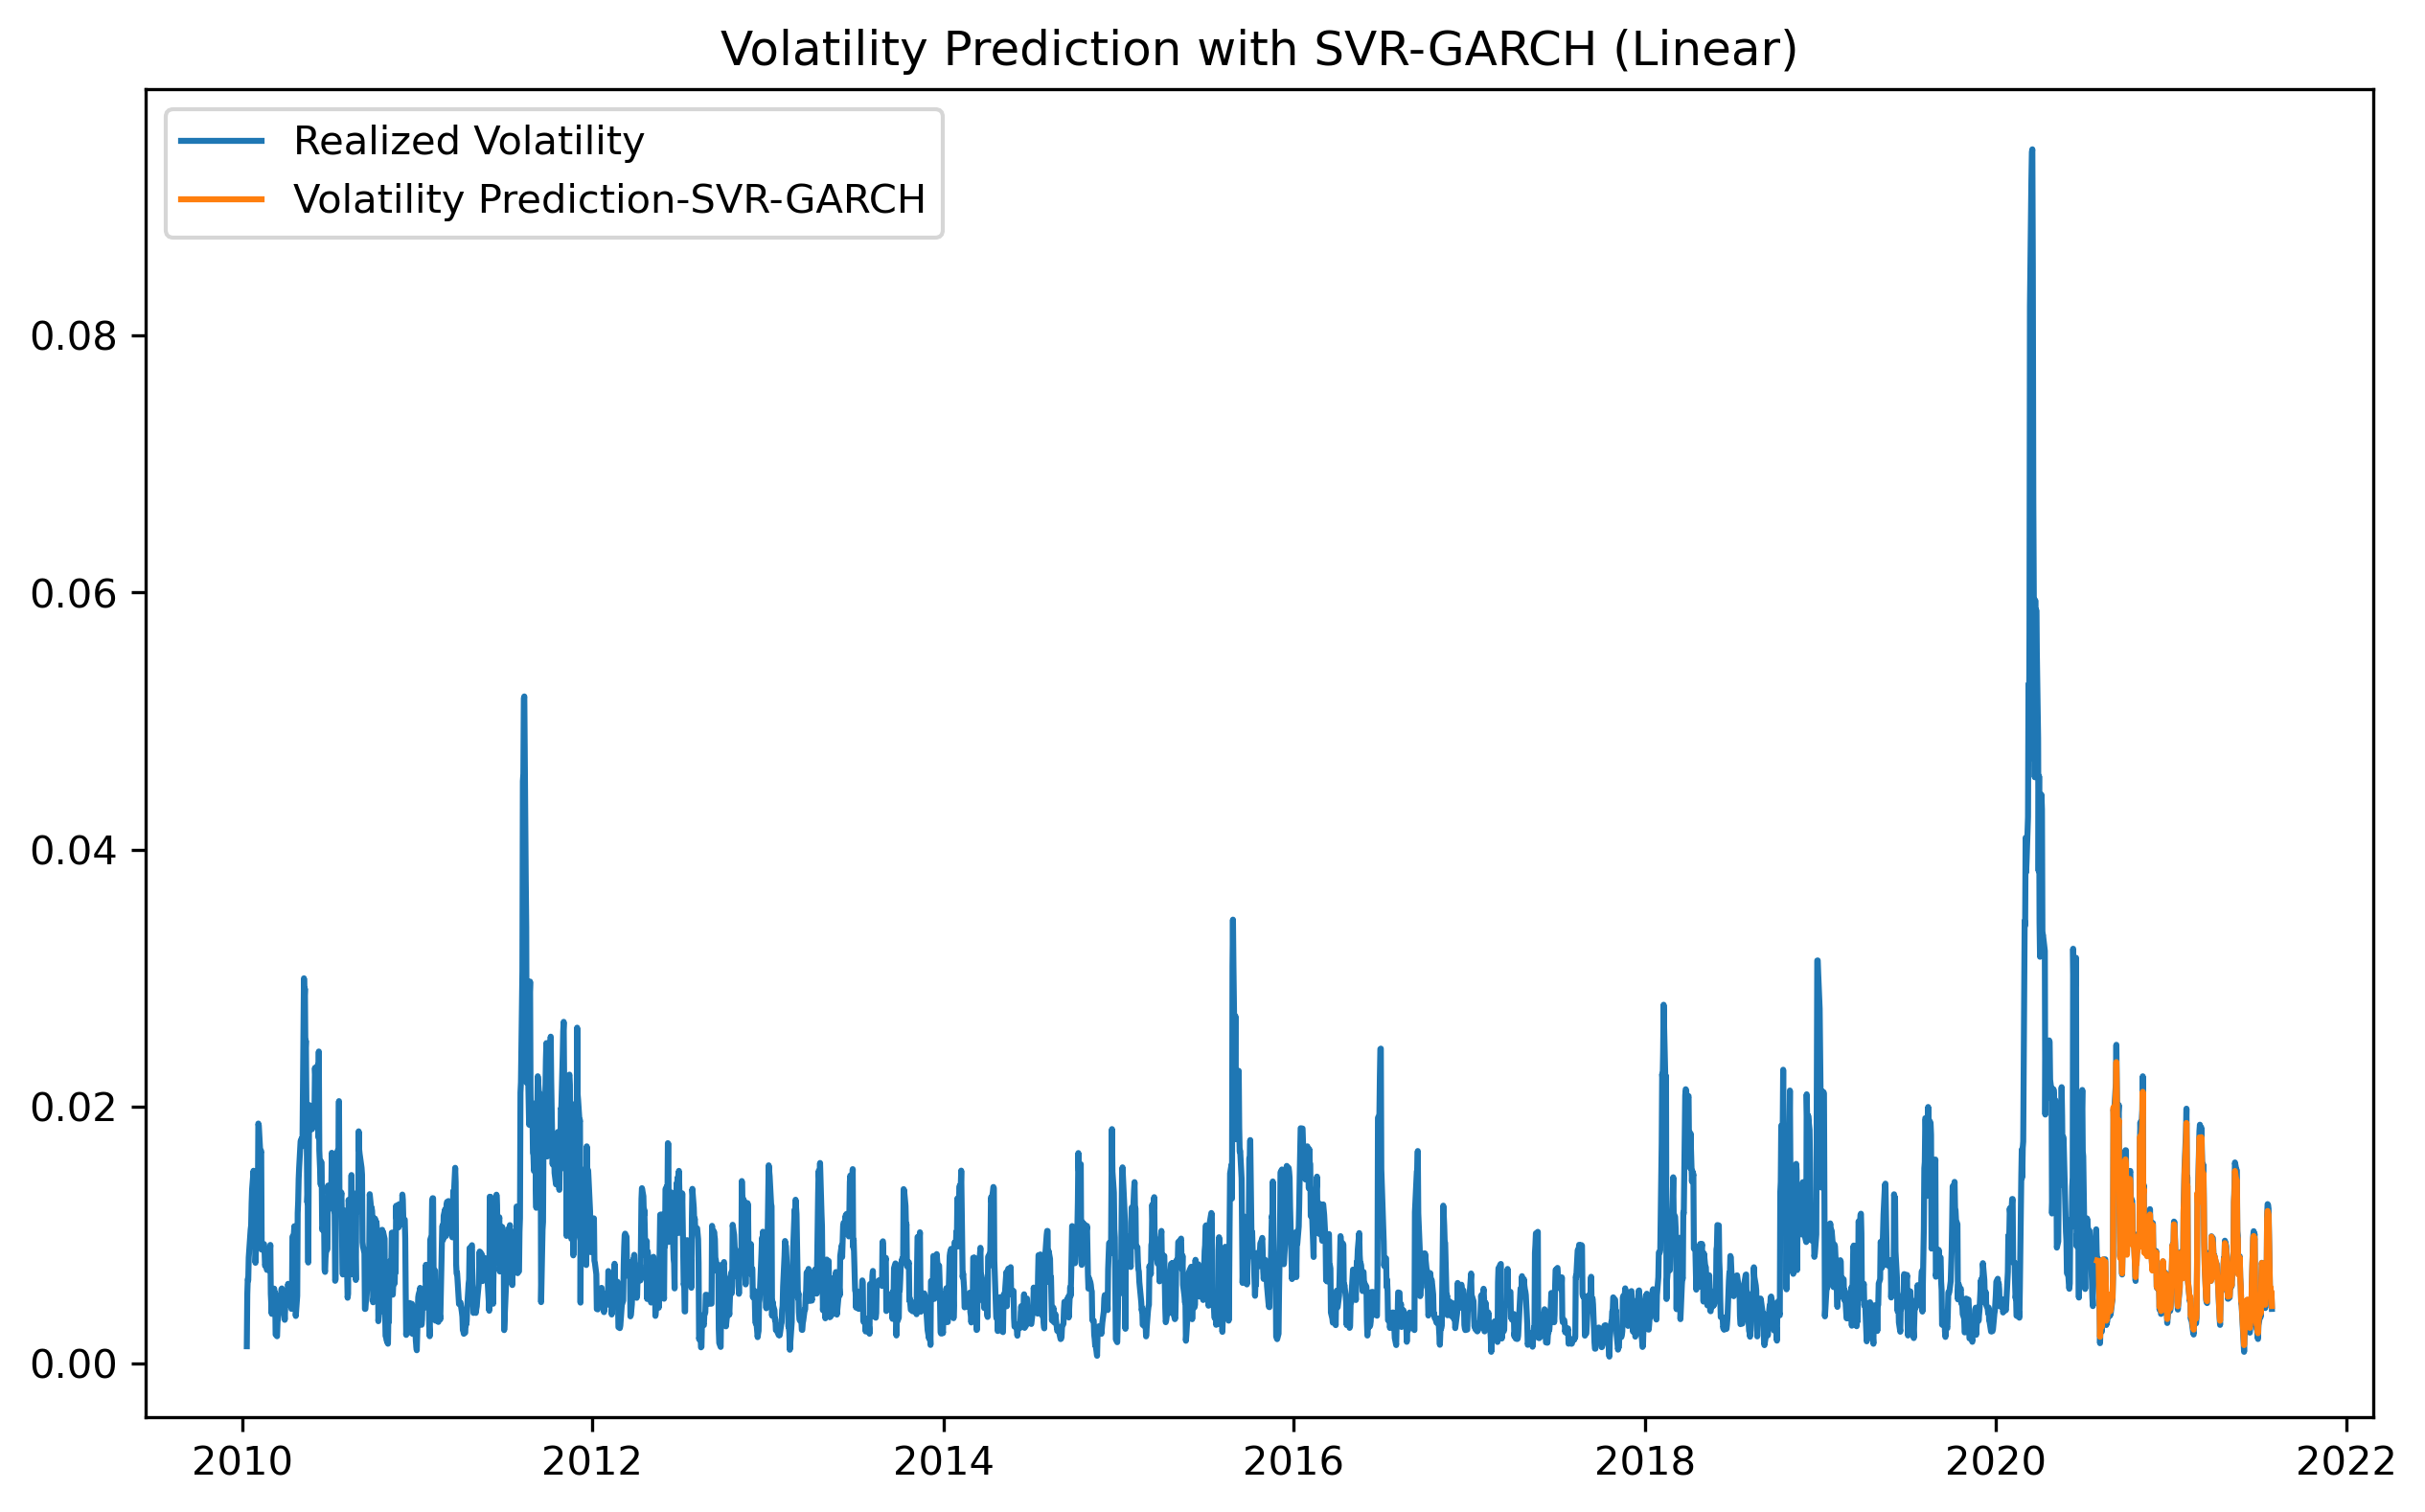

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH RBF

In [49]:
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [50]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [51]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                           predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.000457


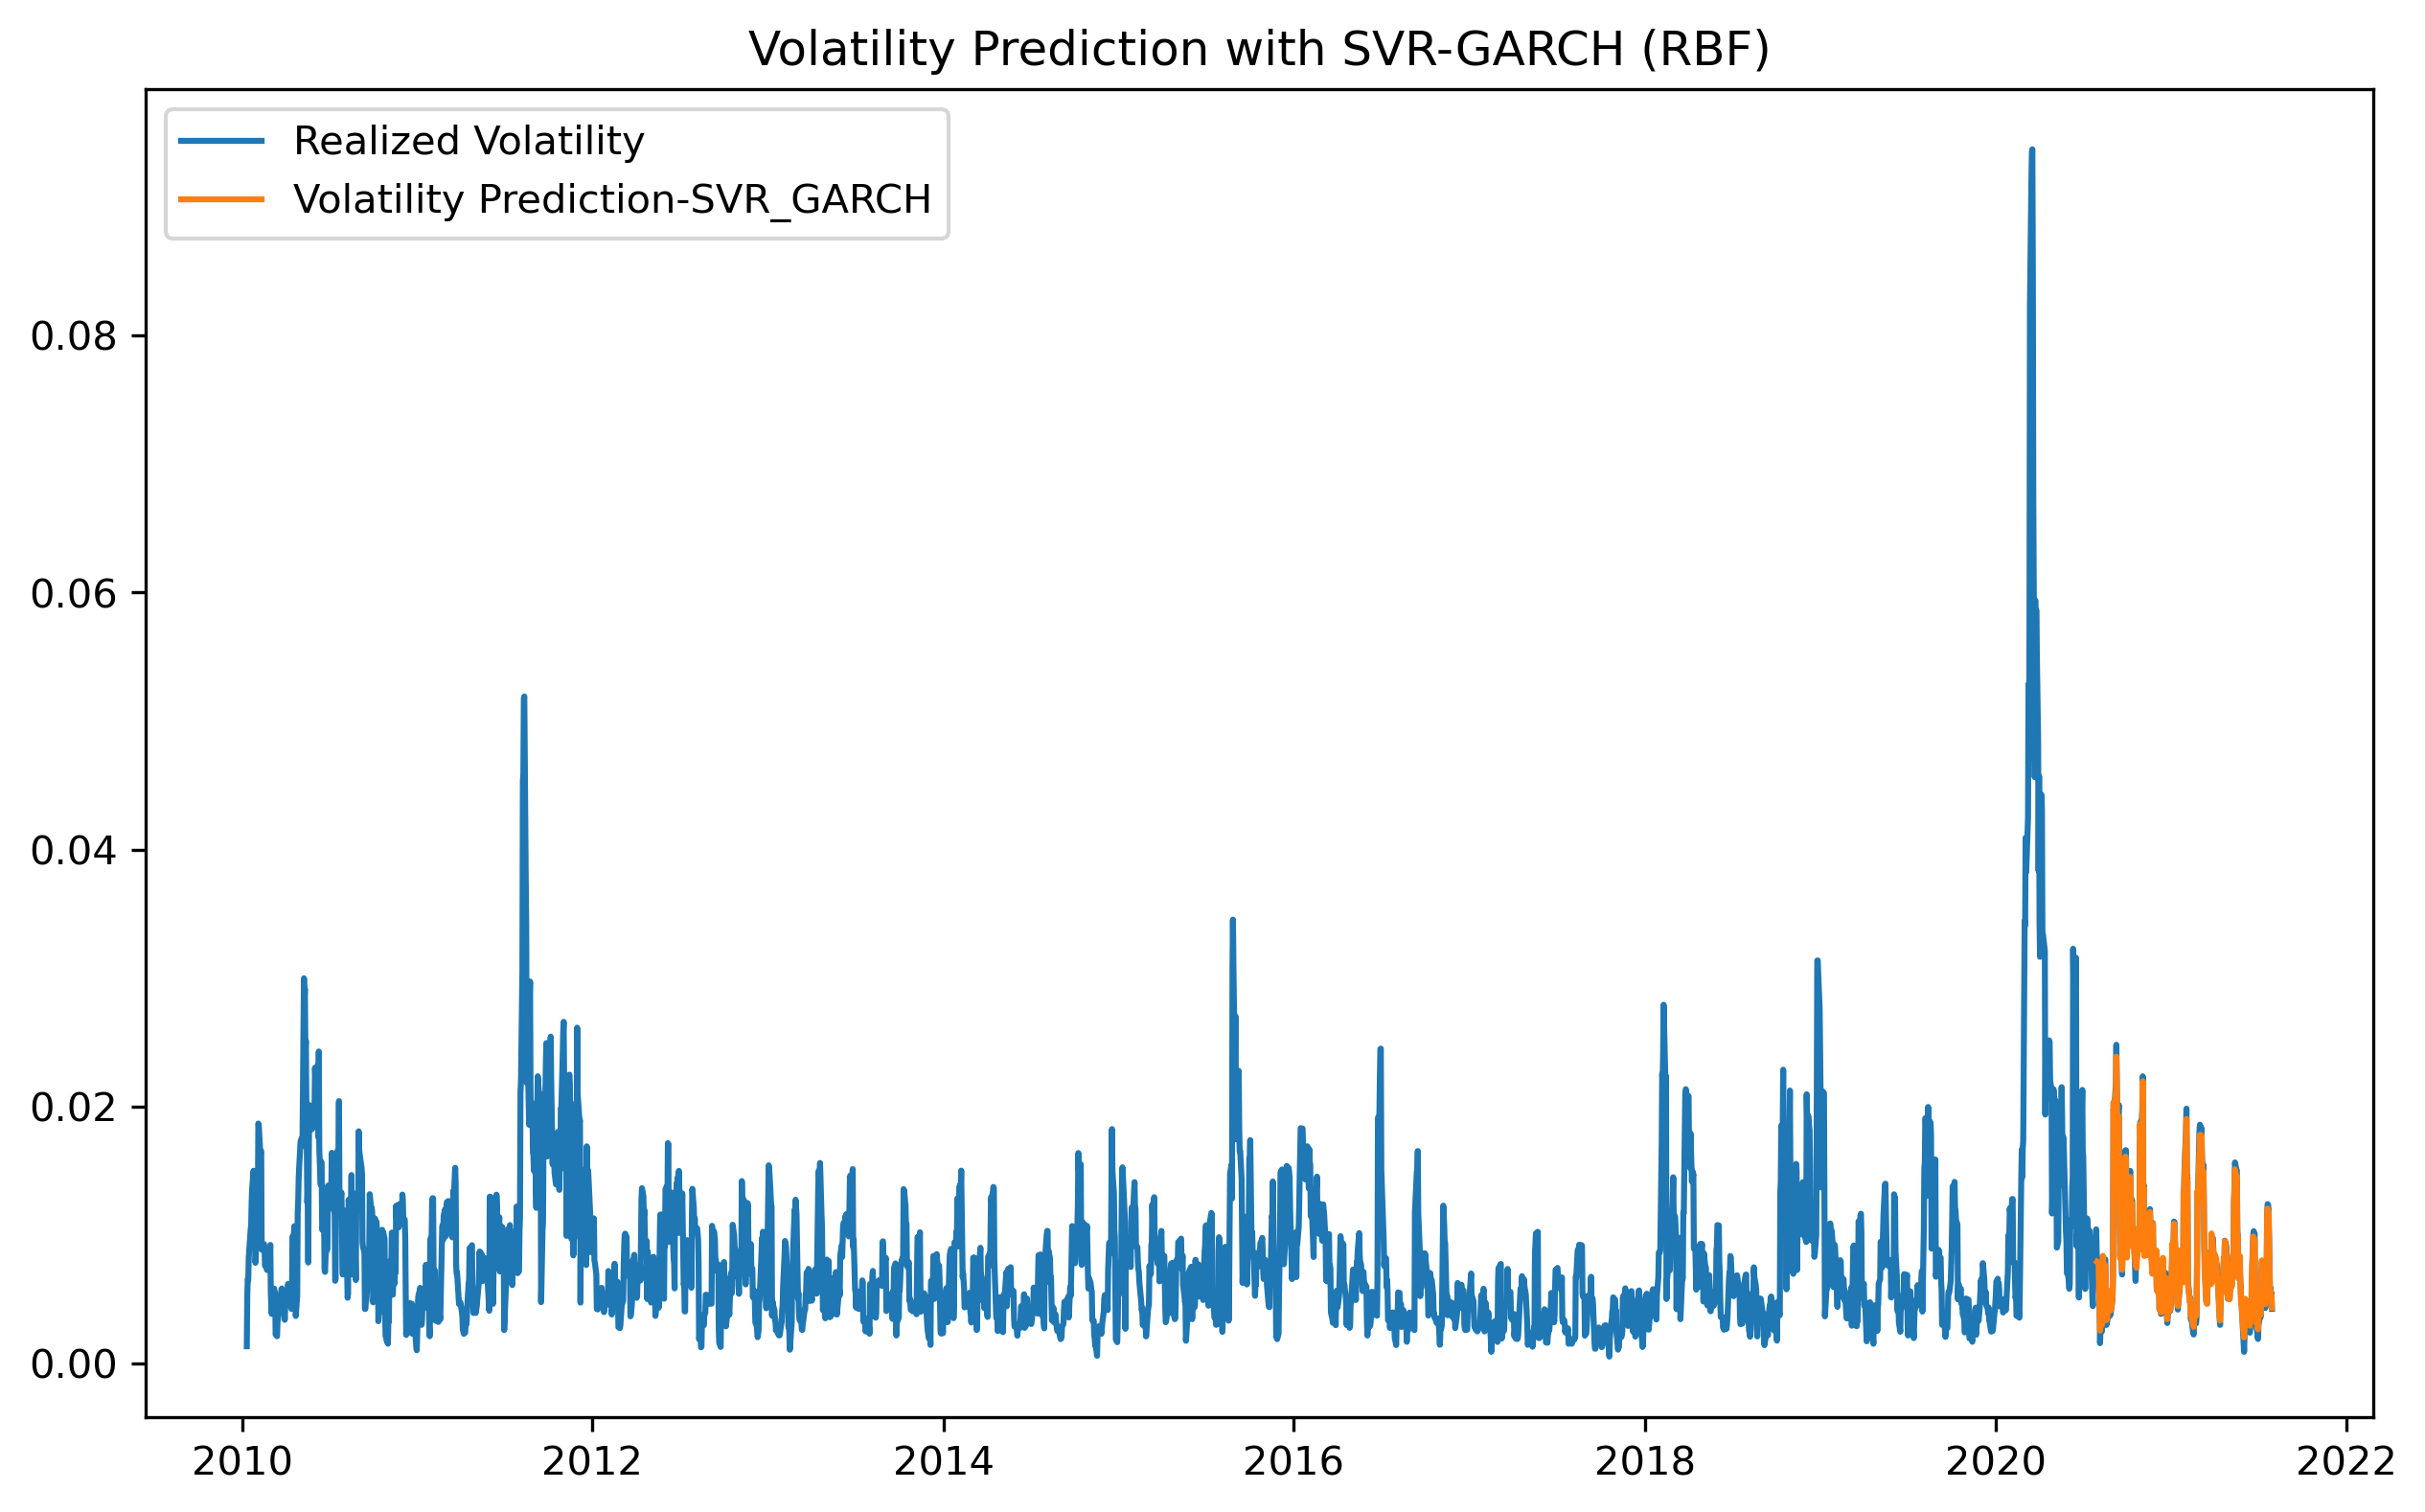

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH Polynomial

In [53]:
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [54]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [55]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'\
      .format(rmse_svr_poly))

The RMSE value of SVR with Polynomial Kernel is 0.002388


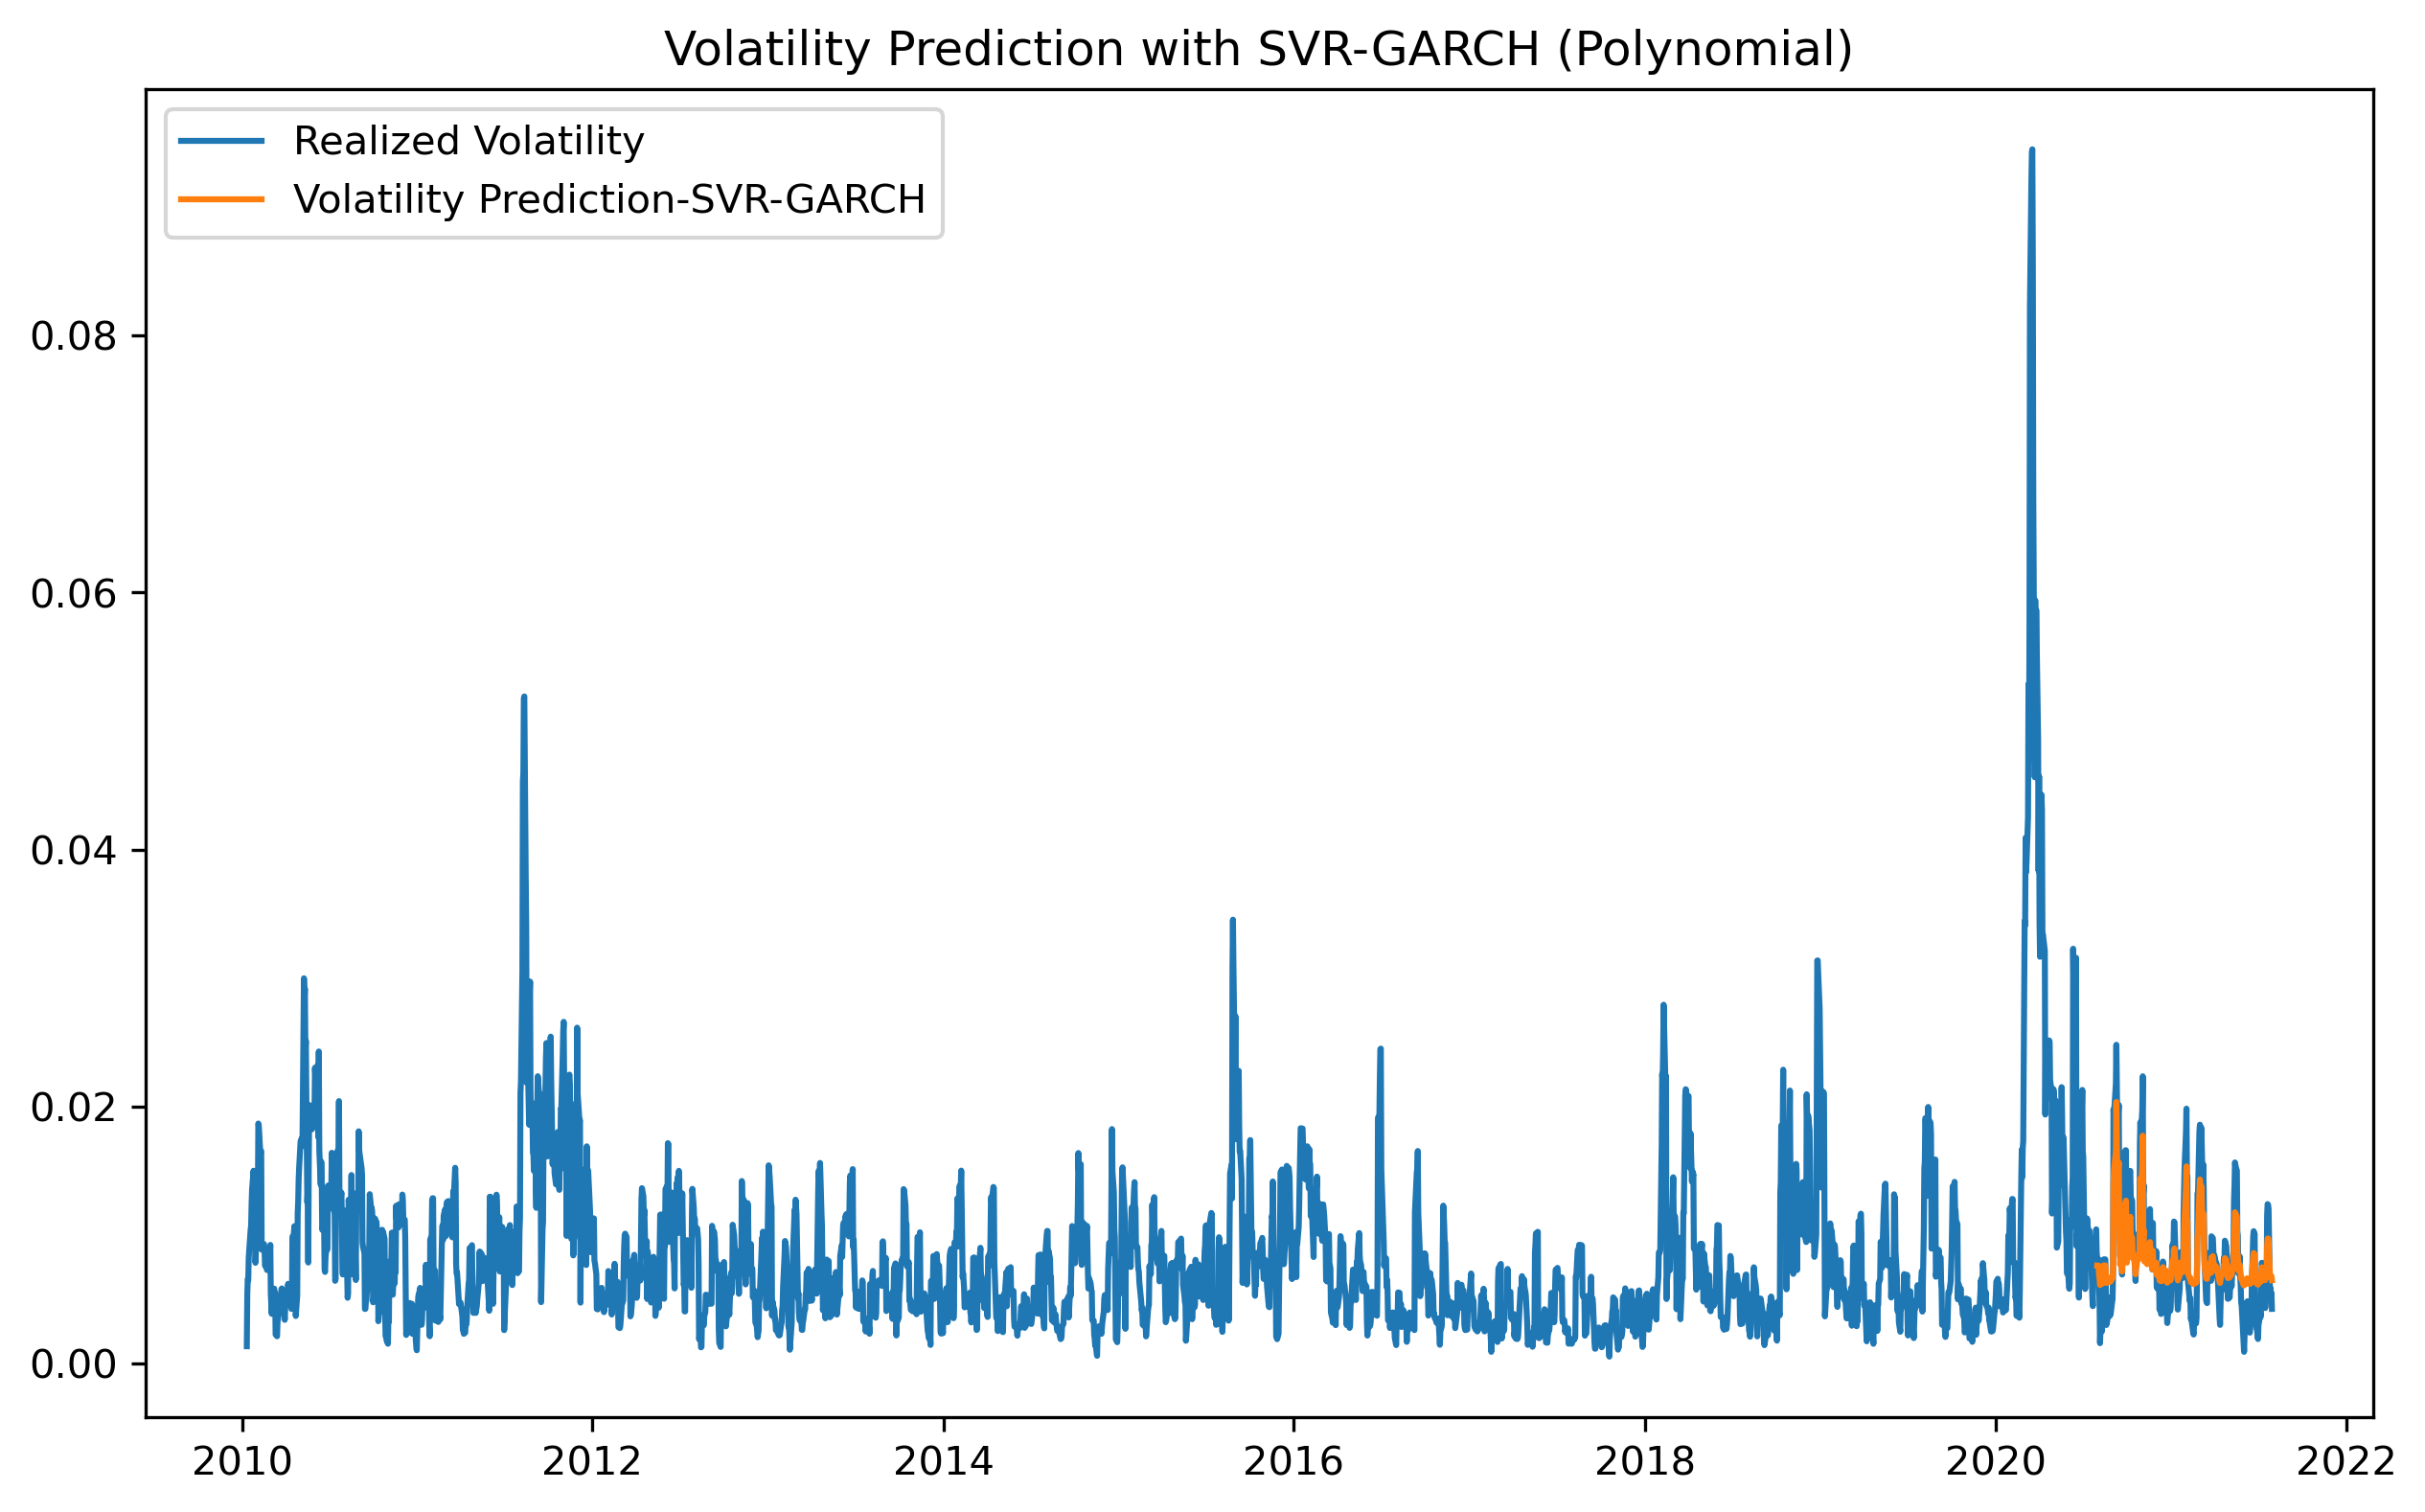

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
          fontsize=12)
plt.legend()
plt.show()

## NN-GARCH

In [58]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1) 
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
               'max_iter': [500, 1000],
               'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

In [59]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [60]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                      NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.000647


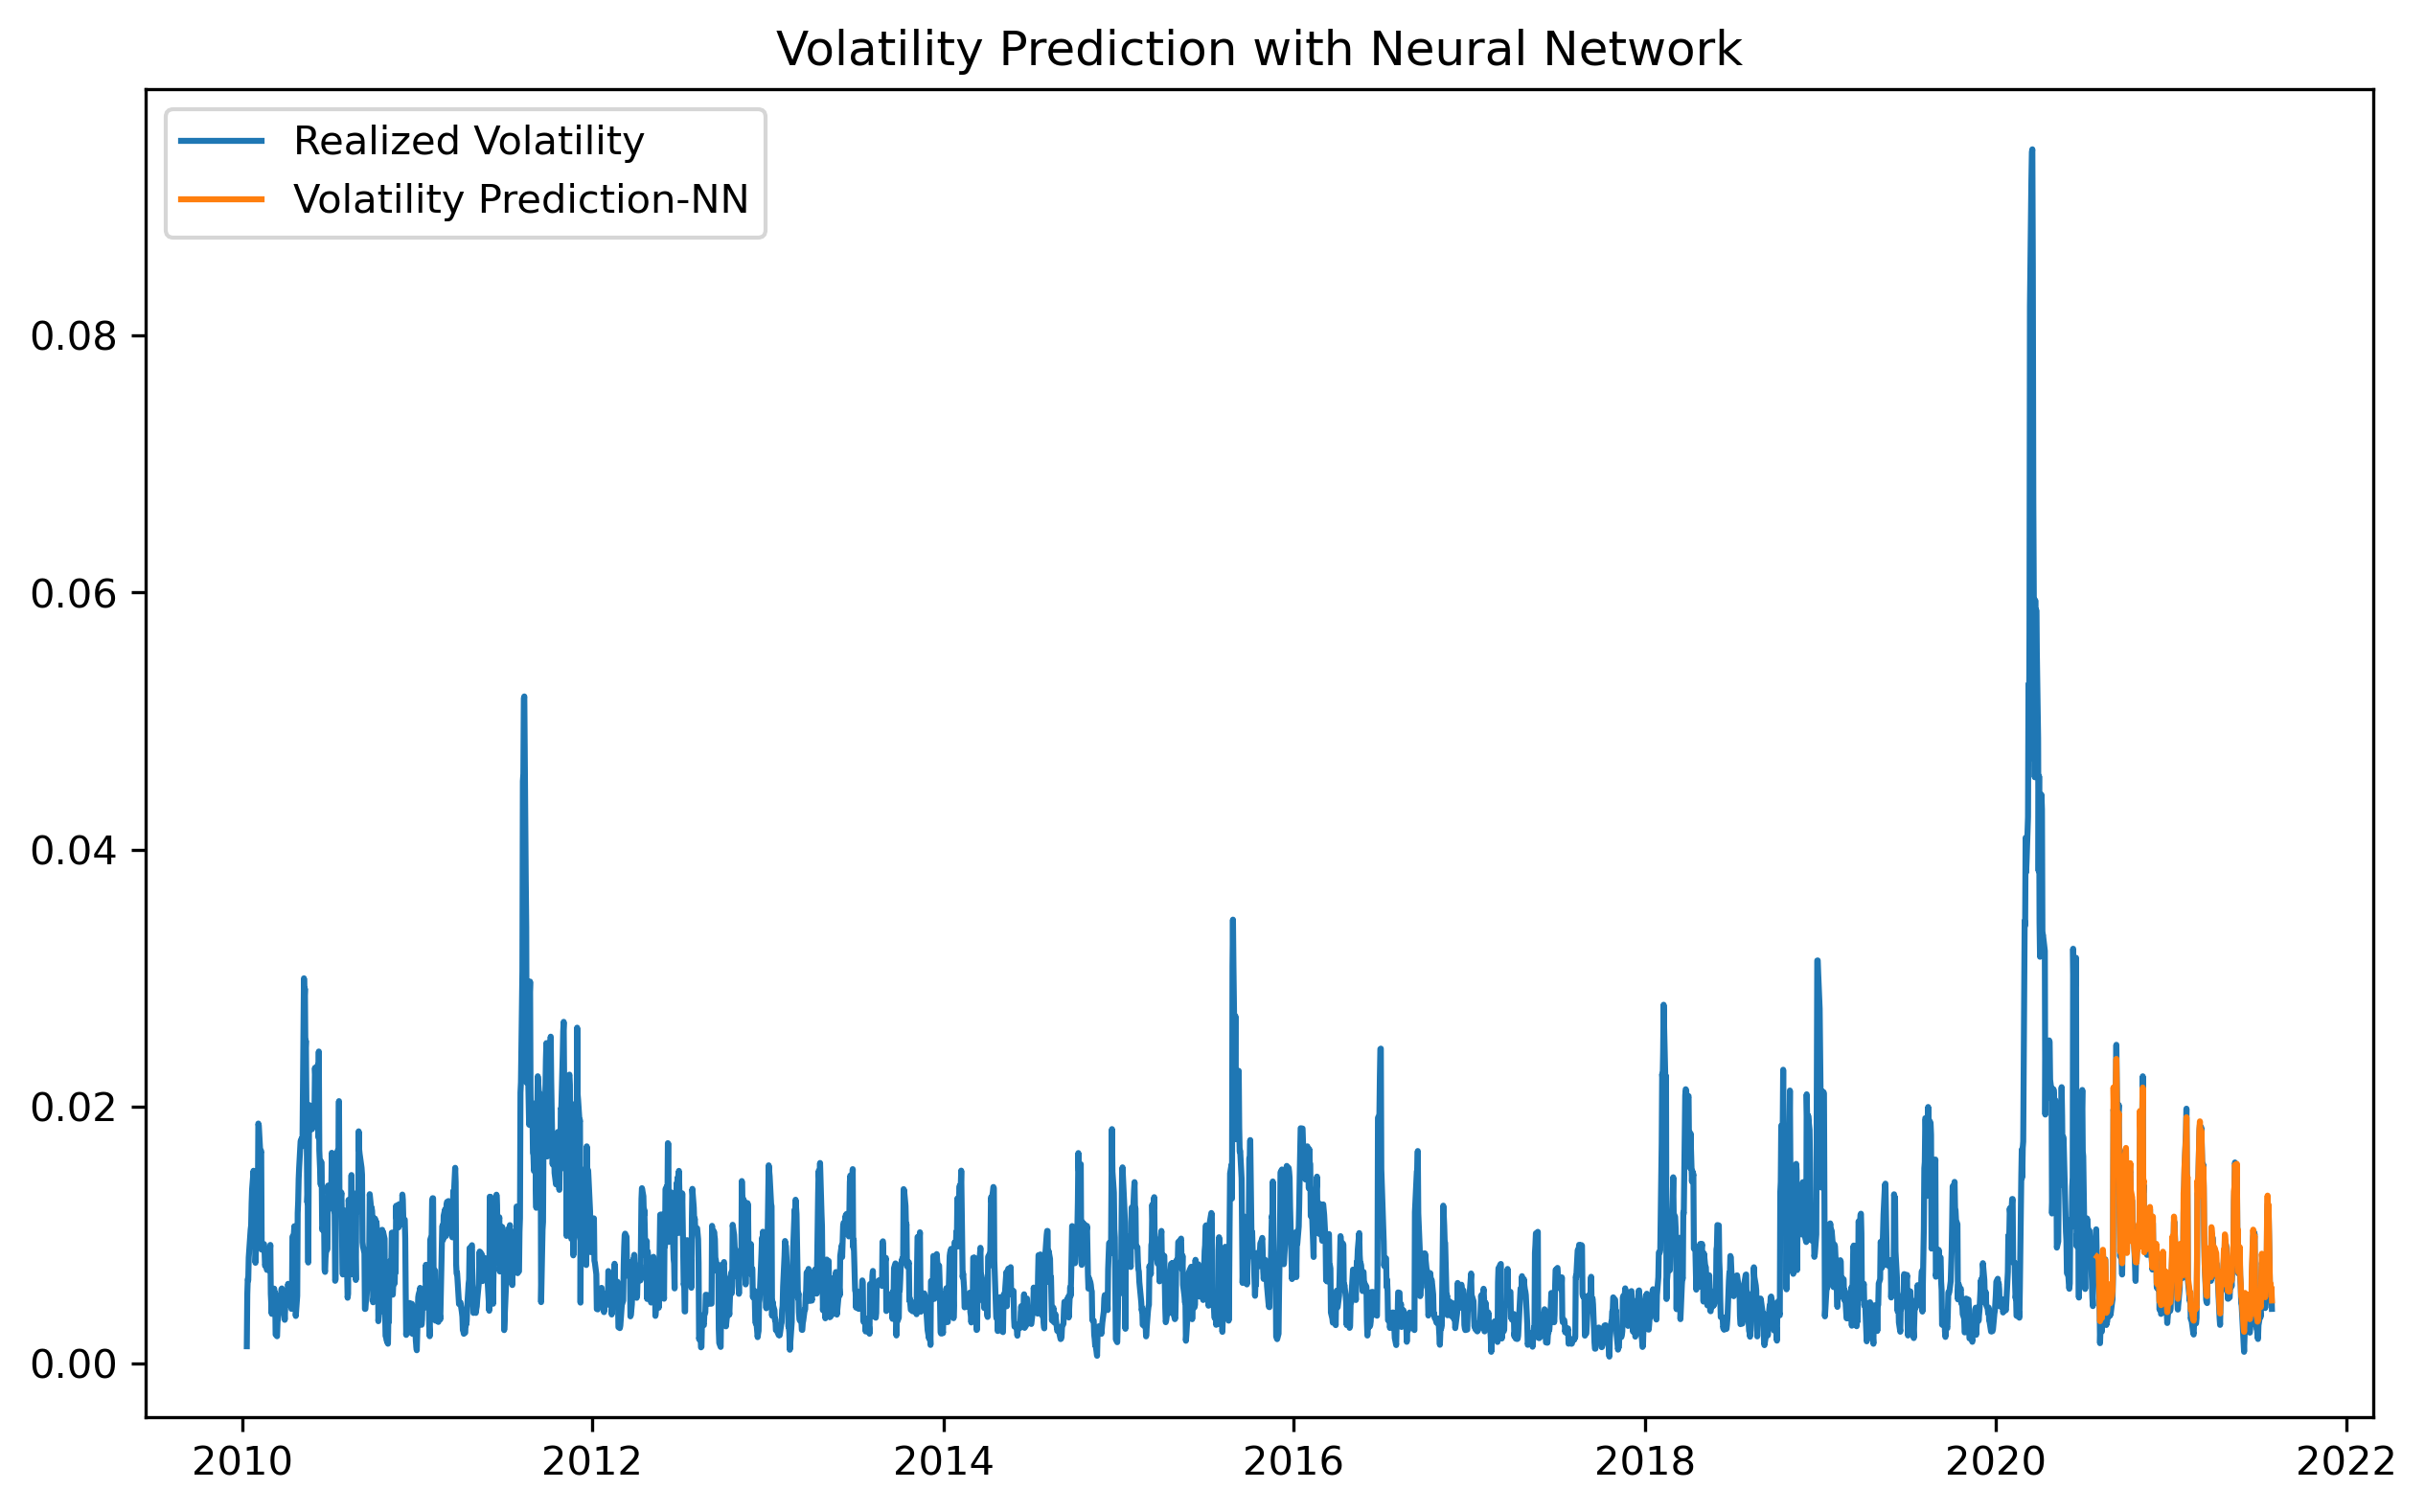

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

## DL-GARCH

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [63]:
model = keras.Sequential(
    [layers.Dense(256, activation="relu"),
     layers.Dense(128, activation="relu"),
     layers.Dense(1, activation="linear"),])

In [64]:
model.compile(loss='mse', optimizer='rmsprop')

In [65]:
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

8/8 [==============================] - 0s 1ms/step
DL_RMSE_1:0.000939
8/8 [==============================] - 0s 904us/step
DL_RMSE_2:0.000661
8/8 [==============================] - 0s 791us/step
DL_RMSE_3:0.000611
8/8 [==============================] - 0s 817us/step
DL_RMSE_4:0.000636


In [66]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

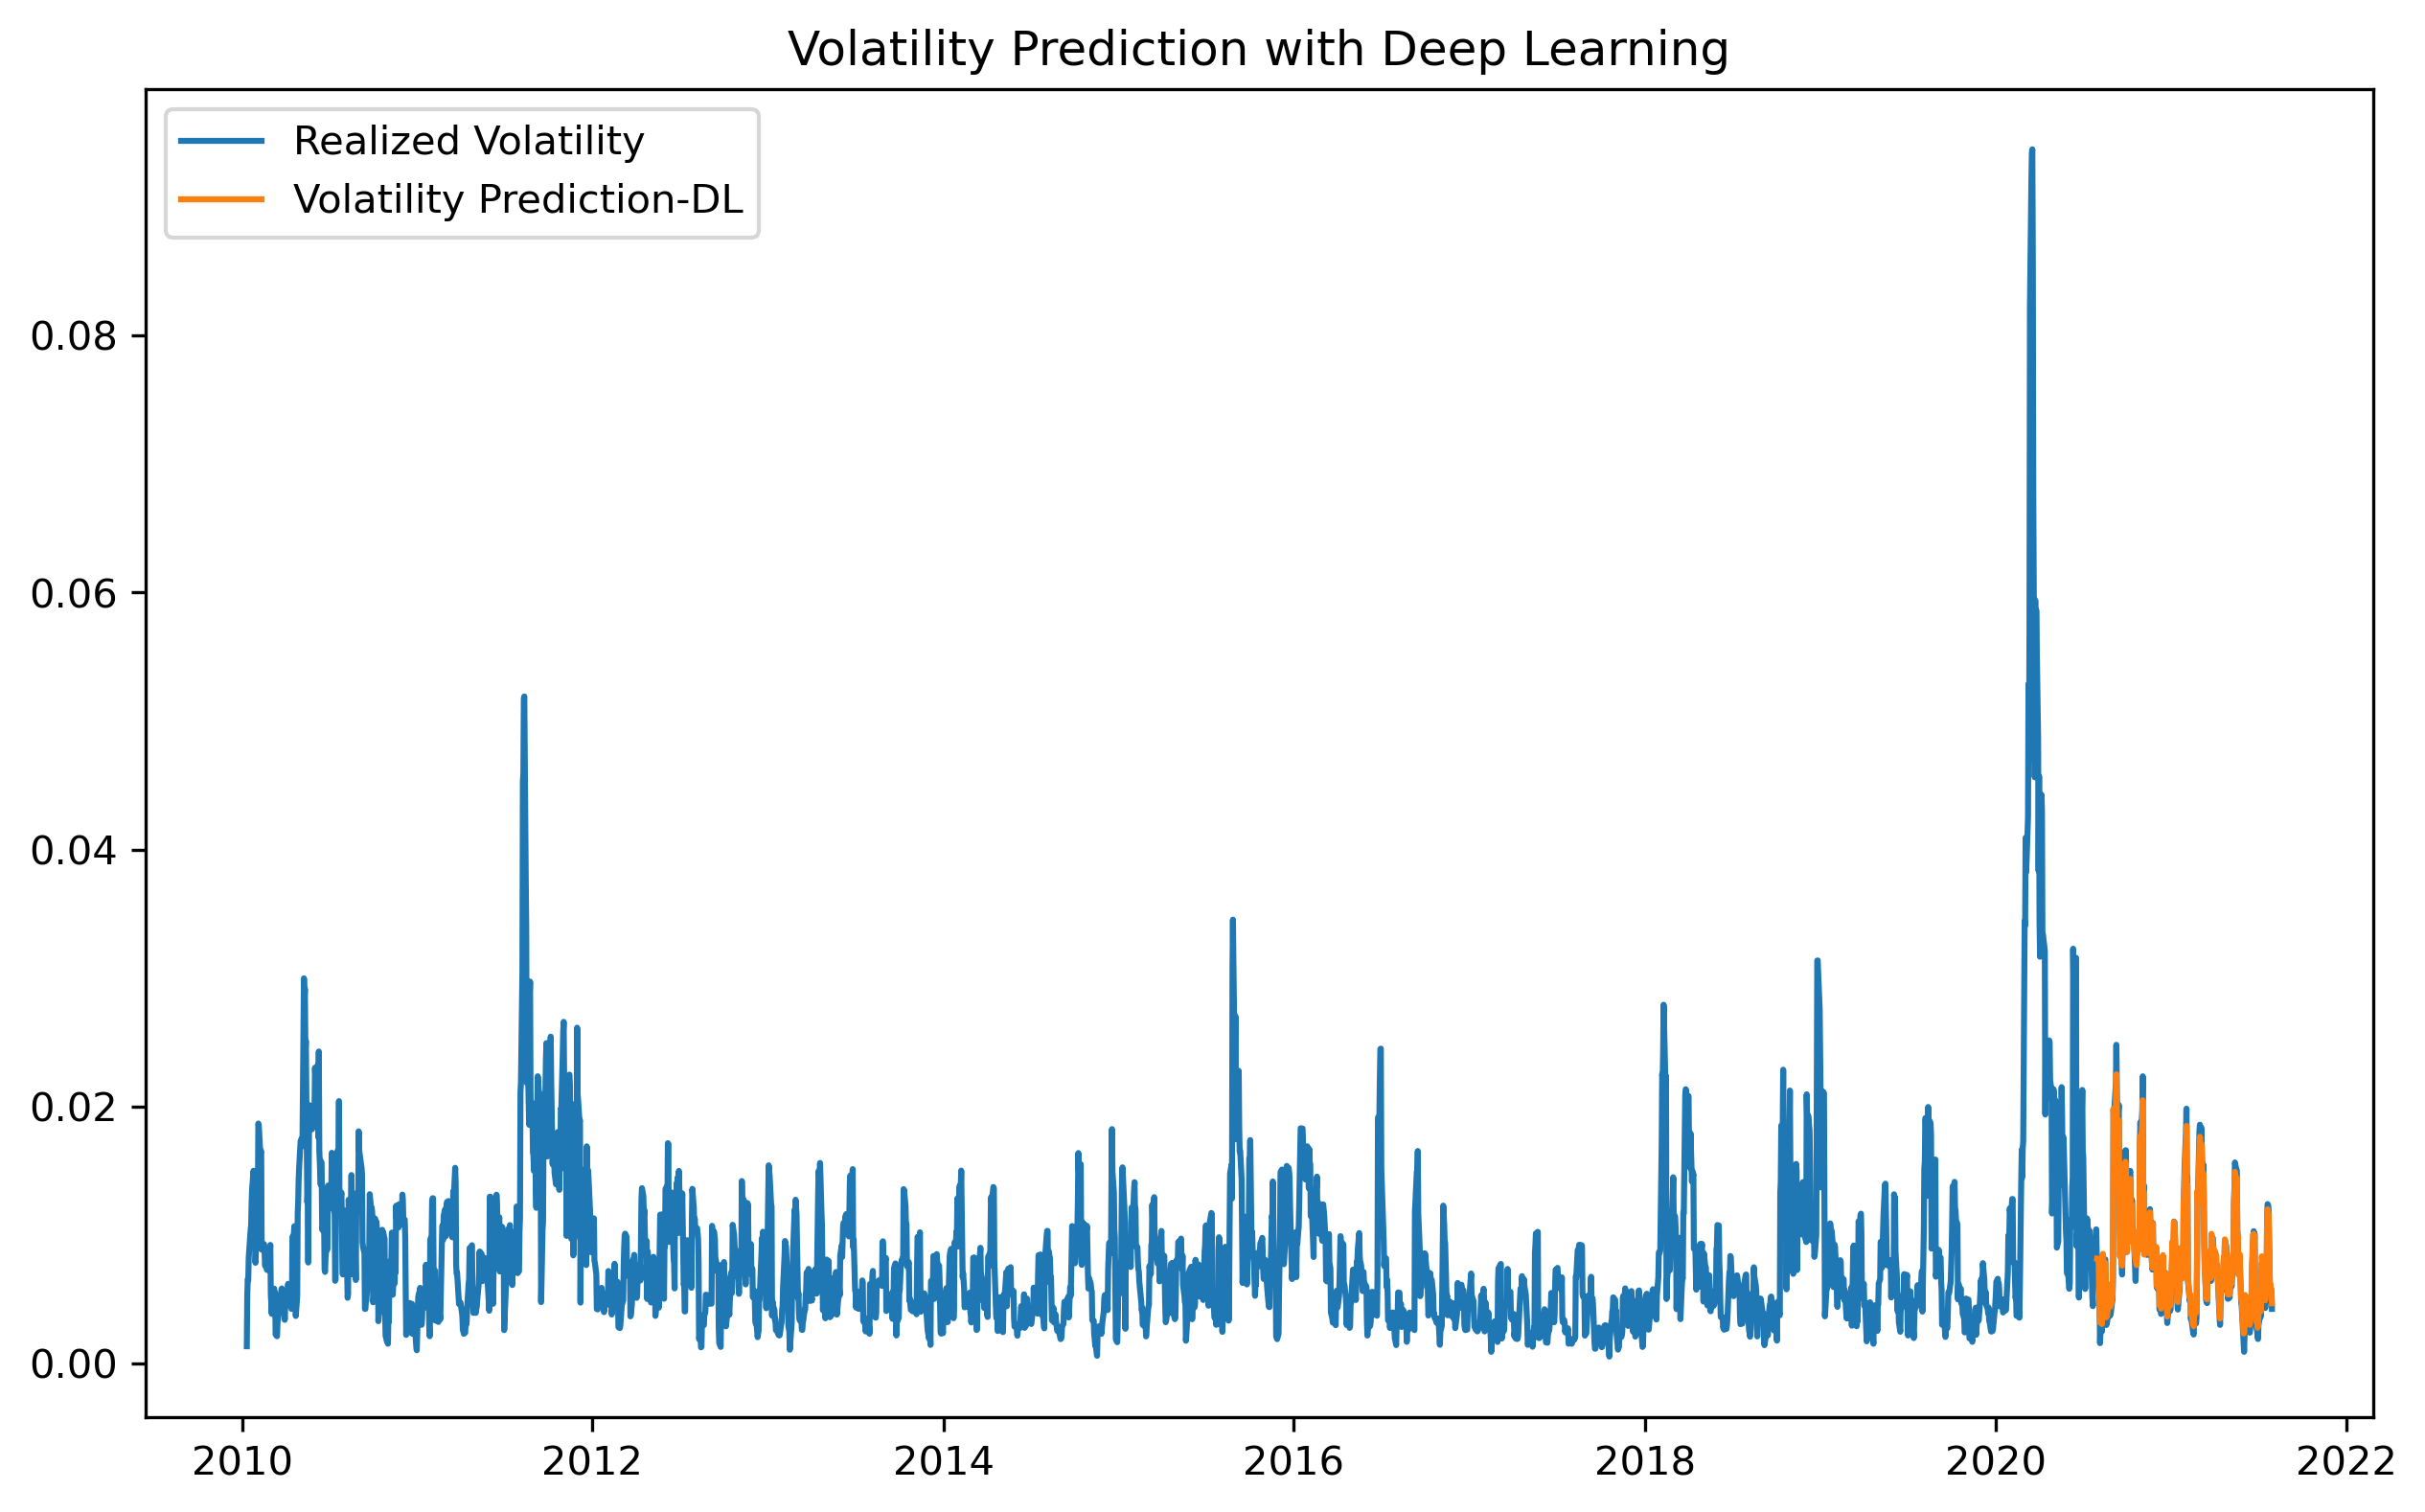

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

## Bayesian Approach

In [68]:
import quantecon as qe
from quantecon import MarkovChain
import networkx as nx
from pprint import pprint 

In [69]:
P = [[0.5, 0.2, 0.3],
     [0.2, 0.3, 0.5],
     [0.2, 0.2, 0.6]]

mc = qe.MarkovChain(P, ('studying', 'travelling', 'sleeping'))
mc.is_irreducible

True

In [70]:
states = ['studying', 'travelling', 'sleeping']
initial_probs = [0.5, 0.3, 0.6]
state_space = pd.Series(initial_probs, index=states, name='states')

In [71]:
q_df = pd.DataFrame(columns=states, index=states)
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.5, 0.2, 0.3]
q_df.loc[states[1]] = [0.2, 0.3, 0.5]
q_df.loc[states[2]] = [0.2, 0.2, 0.6]

In [72]:
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges
edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('sleeping', 'sleeping'): 0.6,
 ('sleeping', 'studying'): 0.2,
 ('sleeping', 'travelling'): 0.2,
 ('studying', 'sleeping'): 0.3,
 ('studying', 'studying'): 0.5,
 ('studying', 'travelling'): 0.2,
 ('travelling', 'sleeping'): 0.5,
 ('travelling', 'studying'): 0.2,
 ('travelling', 'travelling'): 0.3}


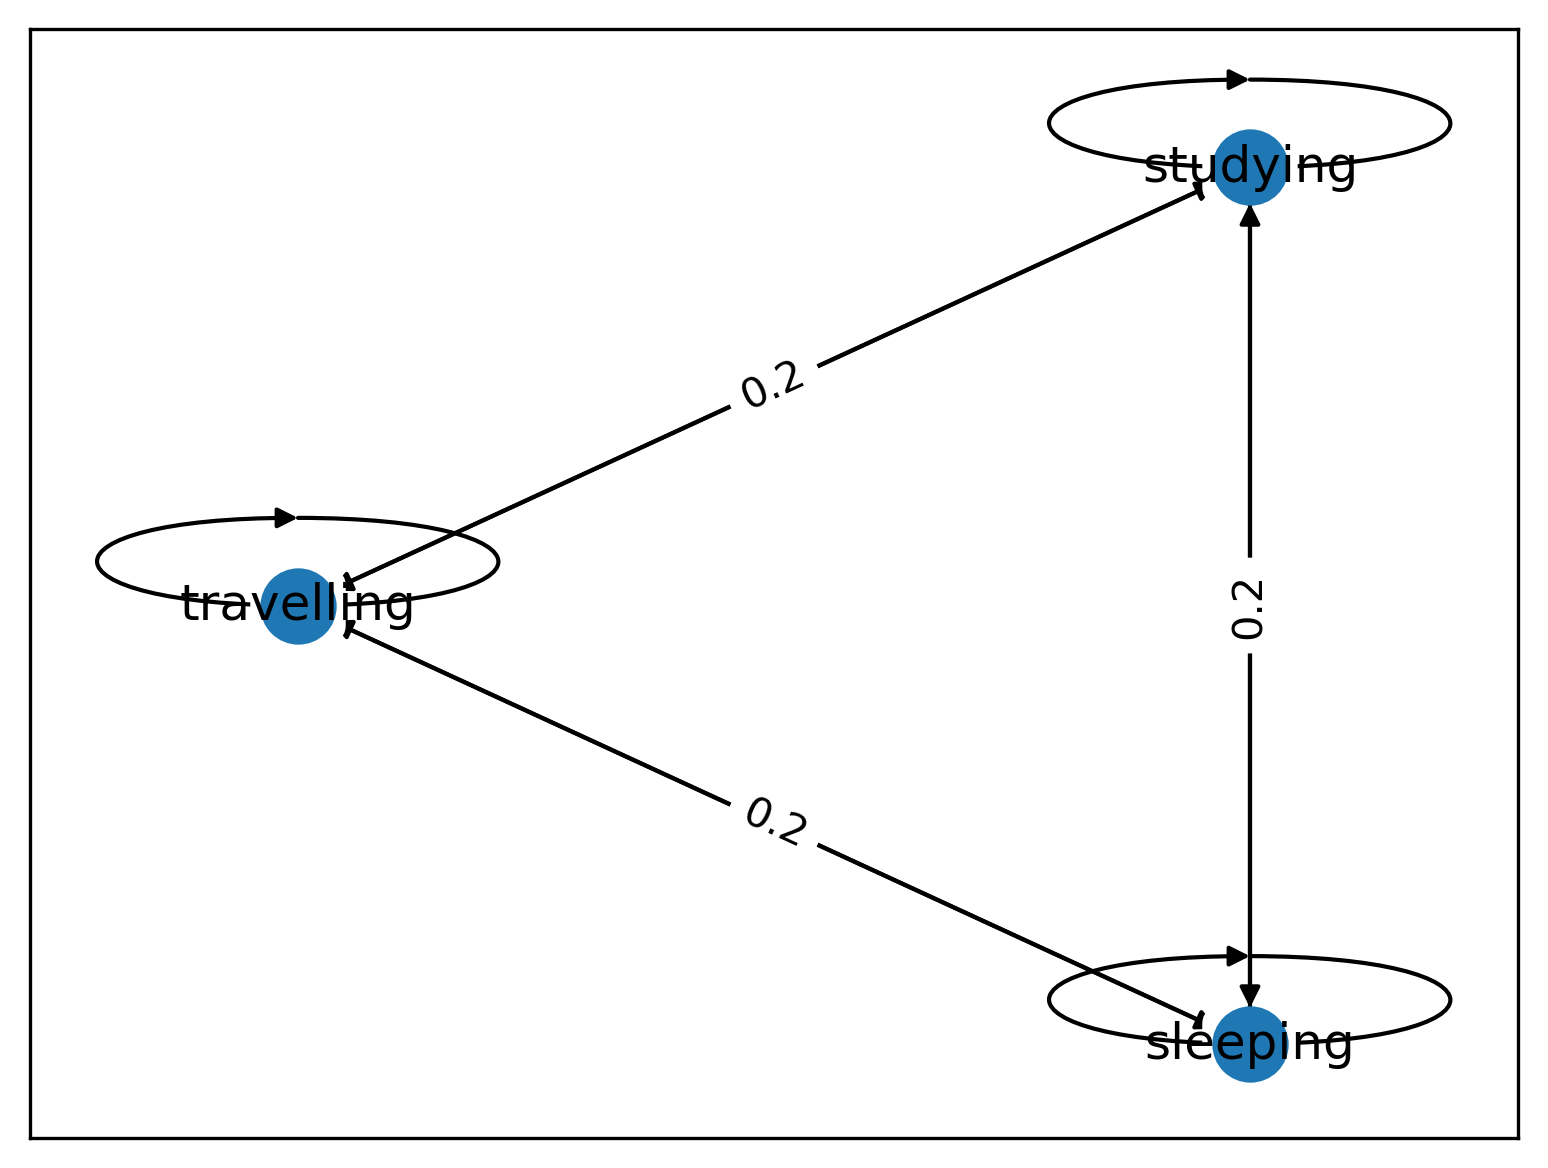

In [74]:
G = nx.MultiDiGraph()
G.add_nodes_from(states)
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)
edge_labels = {(n1, n2):d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'mc_states.dot')

In [76]:
#import pyflux as pf
import arch
from scipy.stats import kurtosis

In [77]:
#model = pf.GARCH(ret.values, p=1, q=1)
model = arch_model(ret.values, vol='garch', p=1, o=0, q=1)
print(model.latent_variables)
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())
x = model.fit(method='M-H', iterations='1000')
print(x.summary())

AttributeError: 'ConstantMean' object has no attribute 'latent_variables'

In [ ]:
model.plot_z([1, 2])
model.plot_fit(figsize=(15, 5))
model.plot_ppc(T=kurtosis, nsims=1000)

In [ ]:
bayesian_prediction = model.predict_is(n, fit_method='M-H')

In [ ]:
bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         bayesian_prediction.values / 100))
print('The RMSE of Bayesian model is {:.6f}'.format(bayesian_RMSE))

In [ ]:
bayesian_prediction.index = ret.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,
         label='Realized Volatility')
plt.plot(bayesian_prediction['Series'] / 100,
         label='Volatility Prediction-Bayesian')
plt.title('Volatility Prediction with M-H Approach', fontsize=12)
plt.legend()
plt.show()